In [22]:
import pandas as pd
import numpy as np

# Libraries for plotting graphs
import seaborn as sns
import matplotlib.pyplot as plt

# Library for saving and loading trained models
import joblib
import json

# Libraries for resampling and Label encoding
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder

# Libraries for model building and player embedding
from keras.models import Model, Sequential
from keras.layers import Input, Concatenate, Embedding, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay


In [23]:
def preprocess_dataset_by_year(year):
    # choose n consecutive datasets preceding current year
    n = 1
    df = None
    for i in range(n):
        year_i = year - i
        if year_i >= 2015:
            year = 2015
        if year_i <= 2007:
            year_i = 2007
            dataset_year = pd.read_csv("datasets/matchups-" + str(year_i) + ".csv")
            df = pd.concat([dataset_year, df])
            break
        dataset_year = pd.read_csv("datasets/matchups-" + str(year_i) + ".csv")
        df = pd.concat([dataset_year, df])

    return df


# Data preprocessing

Checking class imbalance

In [24]:
def handle_class_imbalance(df):
    class_distribution = df['outcome'].value_counts().to_dict()

    # Ploting the class imbalance to analyse the target variable.
    sns.countplot(x='outcome', data=df)
    plt.title('Class Imbalance')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

    print(class_distribution[-1], " ", class_distribution[1])
    # Separating the minority and majority class samples.
    major_class = 1 if class_distribution[1] > class_distribution[-1] else -1
    minor_class = -1 * major_class
    df_majority = df[df.outcome == major_class]
    df_minority = df[df.outcome == minor_class]

    # Upsampling minority class
    df_minority_upsampled = resample(df_minority,
                                    replace=True,  # sampling with replacement
                                    n_samples=len(df_majority),  # matching majority n
                                    random_state=42)  # reproducible results
    df=pd.concat([df_majority, df_minority_upsampled]) #Redefining the dataframe with the upsampled data
    df = df.reset_index(drop = True)

    # Checking the imbalance of the class again.
    class_distribution = df['outcome'].value_counts()
    print(class_distribution)

    # Ploting class imbalance
    sns.countplot(x='outcome', data=df)
    plt.title('Class Imbalance')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.show()

    return df


# Data Transformation

Now encoding the player names since the machine doesnt undertand the textual data.

In [25]:
def get_players_list_by_season_and_team(df):
    players_list_by_team = {}
    for i in range(df.shape[0]):
        season = int(df.loc[i, 'season'])
        home_team = df.loc[i, 'home_team']
        away_team = df.loc[i, 'away_team']
        if season not in players_list_by_team:
            players_list_by_team[season] = {}
        if home_team not in players_list_by_team[season]:
            players_list_by_team[season][home_team] = set()
        if away_team not in players_list_by_team[season]:
            players_list_by_team[season][away_team] = set()
        for j in range(5):
            players_list_by_team[season][home_team].add(df.loc[i, 'home_' + str(j)])
            players_list_by_team[season][away_team].add(df.loc[i, 'away_' + str(j)])
    for year in players_list_by_team:
        for teams in players_list_by_team[year]:
            players_list_by_team[year][teams] = list(players_list_by_team[year][teams])
    return players_list_by_team

In [ ]:
def player_name_encoding(df):
    # Here we are abstracting all the unique home players from all the home columns.
    player_columns = ['home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4']

    # Combining all the players
    all_players = df[player_columns].values.flatten()

    # Initializing and fitting the label encoder
    encoder = LabelEncoder()
    encoder.fit(all_players)

    # Encoding player names in the dataset
    for col in player_columns:
        df.loc[:, col] = encoder.transform(df[col])
    
    # Get the mapping of player names to numbers
    player_name_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

    for players in player_name_mapping:
        player_name_mapping[players] = int(player_name_mapping[players])

    # This code for handling unknown players by reserving embeddings for those unseen players
    for i in range(125):
        player_name_mapping['player_'+str(i)] = len(player_name_mapping)

    return df, player_name_mapping

# Feature Engineering

Based on the research conducted on how to understand the NBA game and statistics, there were four main factors that will decide if a team wins and losses. They encompass the important statistics of the team’s performance which are defined by the following four factors.
The factor formulas are:
•	Shooting the ball
Effective Field Goal Percentage= (Field Goals Made) + 0.5*3P Field Goals Made))/(Field Goal Attempts)
•	Taking care of the ball
Turnover Rate=Turnovers/ (Field Goal Attempts + 0.44*Free Throw Attempts + Turnovers)
•	Offensive rebounding
Offensive Rebounding Percentage = (Offensive Rebounds)/ [(Offensive Rebounds) +(Opponent’s Defensive Rebounds)]
•	Getting to the foul line
Free Throw Rate= (Free Throws Made)/(Field Goals Attempted) or Free Throws Attempted/Field Goals Attempted

Thus utilizing the data available to calculate the above factors for home and away lineups.

In [27]:
def feature_engineering(df):
    # Step 1: Identify useful features
    # Converting class labels from -1 to 0 and 1 to 1
    df['outcome']=(df['outcome']+1)/2

    # Field Goal Percentage
    df['fg_pct_home'] = df['fgm_home'] / df['fga_home'].replace(0, np.nan)

    # Three-Point Percentage
    df['3p_pct_home'] = df['fgm_3_home'] / df['fga_3_home'].replace(0, np.nan)

    # Free Throws Made & Percentage
    df['ftm_home'] = df['pts_home'] - (2 * df['fgm_2_home'] + 3 * df['fgm_3_home'])
    df['ft_pct_home'] = df['ftm_home'] / df['fta_home'].replace(0, np.nan)

    # True Shooting Percentage
    df['ts_pct_home'] = df['pts_home'] / (2 * (df['fga_home'] + 0.44 * df['fta_home'])).replace(0, np.nan)

    # Assist-to-Turnover Ratio
    df['ast_to_ratio_home'] = df['ast_home'] / df['to_home'].replace(0, np.nan)

    # Rebound Rates
    df['off_reb_rate_home'] = df['oreb_home'] / df['reb_home'].replace(0, np.nan)
    df['def_reb_rate_home'] = df['dreb_home'] / df['reb_home'].replace(0, np.nan)

    # Field Goal Percentage
    df['fg_pct_visitor'] = df['fgm_visitor'] / df['fga_visitor'].replace(0, np.nan)

    # Three-Point Percentage
    df['3p_pct_visitor'] = df['fgm_3_visitor'] / df['fga_3_visitor'].replace(0, np.nan)

    # Free Throws Made & Percentage
    df['ftm_visitor'] = df['pts_visitor'] - (2 * df['fgm_2_visitor'] + 3 * df['fgm_3_visitor'])
    df['ft_pct_visitor'] = df['ftm_visitor'] / df['fta_visitor'].replace(0, np.nan)

    # True Shooting Percentage
    df['ts_pct_visitor'] = df['pts_visitor'] / (2 * (df['fga_visitor'] + 0.44 * df['fta_visitor'])).replace(0, np.nan)

    # Assist-to-Turnover Ratio
    df['ast_to_ratio_visitor'] = df['ast_visitor'] / df['to_visitor'].replace(0, np.nan)

    # Rebound Rates
    df['off_reb_rate_visitor'] = df['oreb_visitor'] / df['reb_visitor'].replace(0, np.nan)
    df['def_reb_rate_visitor'] = df['dreb_visitor'] / df['reb_visitor'].replace(0, np.nan)

    # Dropping the unncessary columns
    df.drop(['game', 'starting_min', 'end_min',
        'fga_home', 'fta_home', 'fgm_home',
        'fga_2_home', 'fgm_2_home', 'fga_3_home', 'fgm_3_home', 'ast_home',
        'blk_home', 'pf_home', 'reb_home', 'dreb_home', 'oreb_home', 'to_home',
        'fga_visitor', 'fta_visitor', 'fgm_visitor', 'fga_2_visitor', 'fgm_2_visitor',
        'fga_3_visitor', 'fgm_3_visitor', 'ast_visitor', 'blk_visitor',
        'pf_visitor', 'reb_visitor', 'dreb_visitor', 'oreb_visitor',
        'to_visitor'],inplace=True,axis=1)
    
    # Analysing the percentage of null values in the columns.
    null_counts = df.isnull().sum()

    # Calculating the total number of rows in the DataFrame
    total_rows = len(df)

    # Calculating the percentage of null values for each column
    null_percentage = (null_counts / total_rows) * 100

    print("Percentage of null values for each column:")
    print(null_percentage)

    # Here the percentage of null values is quite low which can be replaced by the 0.
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0,inplace=True)

    # Analysing the percentage of null values in the columns.
    null_counts = df.isnull().sum()

    # Calculating the percentage of null values for each column
    null_percentage = (null_counts / total_rows) * 100

    print("Percentage of null values for each column:")
    print(null_percentage)

    # Creating a box plot to check for the outliers.

    sns.boxplot(data=df[['outcome', 'fg_pct_home', '3p_pct_home',
                         'ftm_home', 'ft_pct_home', 'ts_pct_home',
                         'ast_to_ratio_home', 'off_reb_rate_home',
                         'def_reb_rate_home', 'fg_pct_visitor',
                         '3p_pct_visitor', 'ftm_visitor', 'ft_pct_visitor',
                         'ts_pct_visitor', 'ast_to_ratio_visitor',
                         'off_reb_rate_visitor', 'def_reb_rate_visitor']]).set(title='A plot to check for outliers')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    # Creating a new column by concatenating home players and forming an array representing the home lineup.
    df['home_lineup'] = df.apply(lambda row: (row['home_0'], row['home_1'], row['home_2'], row['home_3'], row['home_4']), axis=1)

    # Creating a new column by concatenating away players and forming an array representing the away lineup.
    df['away_lineup'] = df.apply(lambda row: (row['away_0'], row['away_1'], row['away_2'], row['away_3'], row['away_4']), axis=1)

    return df


# Model for generating embeddings

Tranforming the data to make it ready for the model to generate embeddings

In [28]:
def data_transformation(df):
    # Stacking the arrays along axis=1 to make them understandable by neural network.
    array = np.stack(df['home_lineup'])
    home_array = [', '.join(map(str, row)) for row in array]

    # Defining the home lineups in X_home which will then be used to generate embeddings for each home player.
    X_home= [[int(x) for x in row.split(', ')] for row in home_array]
    X_home = np.array(X_home)

    array = np.stack(df['away_lineup'])
    away_array = [', '.join(map(str, row)) for row in array]

    # Defining the away lineups in X_away which will then be used to generate embeddings for each away player.
    X_away= [[int(x) for x in row.split(', ')] for row in away_array]
    X_away = np.array(X_away)

    # Defining the target variable which is the outcome of the game.
    y=df['outcome']

    # Defining the statistics for home and away lineups in X_stats.
    X_stats=df[['fg_pct_home','3p_pct_home',
                'ftm_home', 'ft_pct_home',
                'ts_pct_home', 'ast_to_ratio_home',
                'off_reb_rate_home', 'def_reb_rate_home',
                'fg_pct_visitor', '3p_pct_visitor',
                'ftm_visitor', 'ft_pct_visitor',
                'ts_pct_visitor', 'ast_to_ratio_visitor',
                'off_reb_rate_visitor', 'def_reb_rate_visitor']]

    return X_home, X_away, X_stats, y


Generate Player Embeddings using transformed data

In [29]:
def generate_player_embedding(X_home, X_away, X_stats, y, player_name_mappings):
    num_stats=X_stats.shape[1] # We have eight stats for home and eight stats for away teams.

    home_player_comb_input = Input(shape=(5,)) # Since the combinations are of 5 players.
    away_player_comb_input = Input(shape=(5,))
    stats_input = Input(shape=(num_stats,))  # Assuming num_stats is the number of stats per combination.

    # Adding the embedding layer for home player combinations
    home_player_embedding_layer = Embedding(input_dim=len(player_name_mappings), output_dim=32, name='home_embedding')(home_player_comb_input)
    flattened_home_player_embedding = Flatten()(home_player_embedding_layer)

    # Adding embedding layer for away player combinations.
    away_player_embedding_layer = Embedding(input_dim=len(player_name_mappings), output_dim=32, name='away_embedding')(away_player_comb_input)
    flattened_away_player_embedding = Flatten()(away_player_embedding_layer)

    # Concatenating the flattened player embeddings with stats input.
    concatenated_features = Concatenate()([flattened_home_player_embedding, flattened_away_player_embedding, stats_input])

    # Adding dense layers for further processing.
    hidden_layer = Dense(32, activation='relu')(concatenated_features)

    output_layer = Dense(1, activation='sigmoid')(hidden_layer)

    # Defining the model
    model = Model(inputs=[home_player_comb_input, away_player_comb_input, stats_input], outputs=output_layer)

    # Defining the initial learning rate.
    initial_learning_rate = 0.001
    opt = Adam(learning_rate=initial_learning_rate)

    # Defining loss function as binary_crossentropy sice the target variable is binary.
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    # Define learning rate scheduler to automatically change the learning rate by monitoring the validation loss.
    change_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001, verbose=1)

    # Defining early stopping criteria in order to avoid overfitting.
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

    # Printing model summary
    model.summary()

    # Training the model with learning rate schedule.
    home_history = model.fit([X_home, X_away, X_stats], y, epochs=50, batch_size=32, validation_split=0.2,callbacks=[change_lr, early_stop])

    return model

In [30]:
def map_player_embedding(df, model):
    # Storing the weights which are the 32-dimensional feature vectors for the home players in the dictionary.
    home_weights=model.get_layer('home_embedding').get_weights()[0]
    home_player_weights = {index: array for index, array in enumerate(home_weights)}
    
    # Storing the weights which are the 32-dimensional feature vectors for the away players in the dictionary.
    away_weights=model.get_layer('away_embedding').get_weights()[0]
    # Using dictionary comprehension
    away_player_weights = {index: array for index, array in enumerate(away_weights)}

    # Mapping these 32 dimensional vectors in the datframe.
    for col in ['home_0', 'home_1', 'home_2', 'home_3', 'home_4']:
        df[col] = df[col].map(home_player_weights)

    for col in ['away_0', 'away_1', 'away_2', 'away_3', 'away_4']:
        df[col] = df[col].map(away_player_weights)

    # Preparing the X and y variables for our final classification model to classify embeddings as win or loss.
    X = df[['home_0', 'home_1', 'home_2', 'home_3', 'home_4', 'away_0', 'away_1', 'away_2', 'away_3', 'away_4']].values
    y = df['outcome'].values
    X_flat = np.vstack([np.concatenate(arr) for arr in X])

    return X_flat, y


# Model Building for classifying the embeddings.

# Logistic regression

In [31]:
def split_lr_train_test_data(X, y):
    # Splitting data into training and testing sets.
    # X_train, X_test, y_train, y_test =
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train logistic regression model
def train_test_logistic_regression(X, y):
    # Defining the logistic regression model.
    lr_model = LogisticRegression(max_iter=10000)

    lr_model.fit(X, y)

    return lr_model


In [32]:
# Function to predict results using logistic regression model
def predict_logistic_regression(model, X):
    # Making predictions
    return model.predict(X)


In [33]:
def generate_classification_report(y_test, y_pred):
    # Calculating and printing classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


In [34]:
# Plot model results
def plot_logistic_regression_model_diagnostics(model, X_test, y_test):
    """Create three-panel diagnostic plot for classification models"""
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig


# SVM

In [35]:
def split_svm_train_test_data(X, y):
    # Scale the features - crucial for SVM performance
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Split the scaled data
    # X_train, X_test, y_train, y_test = 
    return train_test_split(
        X_flat_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y  # Ensure balanced split
    )

def train_support_vector_machines(X, y):
    # Create optimized LinearSVC model
    svm_model = LinearSVC(
        dual='auto',          # Let sklearn choose the best solver
        C=1.0,               # Regularization parameter
        max_iter=2000,       # Increase max iterations for convergence
        class_weight='balanced',  # Handle class imbalance
        random_state=42,
        tol=1e-4            # Tolerance for stopping criterion
    )

    # Train the model
    print("Training model...")
    svm_model.fit(X, y)

    return svm_model

def predict_svm(svm_model, X):
    # Make predictions
    print("Making predictions...")
    return svm_model.predict(X)

def view_svm_results(svm_model, y_test, y_pred):
    # Print results
    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Get feature importances (absolute values of coefficients)
    feature_importance = np.abs(svm_model.coef_[0])
    top_features = np.argsort(feature_importance)[-5:]  # Get top 5 features
    print("\nTop 5 most important features:")
    for idx in reversed(top_features):
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")


In [36]:
def plot_svm_diagnostics(model, X_test, y_test):
    """Create diagnostic plots for SVM model"""
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and decision scores
    y_pred = model.predict(X_test)
    decision_scores = model.decision_function(X_test)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, decision_scores)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()

    # Print performance summary
    print(f"Test Accuracy: {model.score(X_test, y_test):.3f}")
    print("\nTop 5 Features:")
    feature_importance = np.abs(model.coef_[0])
    for idx in np.argsort(feature_importance)[-5:][::-1]:
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")
    return fig


# Neural Networks

In [37]:
def split_nn_train_test_data(X, y):
    # Scale the features
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Split the scaled data
    # X_train, X_test, y_train, y_test = 
    return train_test_split(
        X_flat_scaled,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )

def train_neural_network_model(X_train, X_test, y_train, y_test):
    # Define a more sophisticated model architecture
    model = Sequential([
        # Input layer with batch normalization
        Dense(512, input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Hidden layers with decreasing neurons
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        # Output layer
        Dense(1, activation='sigmoid')
    ])

    # Compile with a lower initial learning rate
    optimizer = Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Enhanced callbacks
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=8,
        verbose=1,
        restore_best_weights=True
    )

    checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # Train the model with a larger batch size
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        callbacks=[reduce_lr, early_stop, checkpoint],
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    return model

def predict_neural_network_model(model, X_test):
    # Make predictions and calculate metrics
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)
    return y_pred, y_pred_classes

def evaluate_nn_metrics(y_test, y_pred, y_pred_classes):
    # Calculate detailed metrics
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred_classes)

    print("\nDetailed Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes))


In [38]:
def plot_nn_diagnostics(model, X_test, y_test):
    # Create figure
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    return fig


# Random Forest

In [39]:
def split_random_forest_train_test_data(X, y):
    # Scale features - this is important but not computationally heavy
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality while preserving 95% of variance
    print("Applying PCA...")
    pca = PCA(n_components=0.95, random_state=42)
    X_flat_reduced = pca.fit_transform(X_flat_scaled)
    print(f"Reduced dimensions from {X_flat_scaled.shape[1]} to {X_flat_reduced.shape[1]} features")

    # Stratified split to handle class imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat_reduced,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test, scaler, pca

def train_random_forest_model(X, y):
    # Create a more efficient but improved model
    rf_model = RandomForestClassifier(
        n_estimators=100,        # Moderate number of trees
        max_depth=15,           # Reasonable depth
        min_samples_split=10,   # Balanced value
        min_samples_leaf=4,     # Balanced value
        max_features='sqrt',    # Reduces feature consideration at each split
        n_jobs=2,              # Use only 2 CPU cores to prevent freezing
        class_weight='balanced', # Handle class imbalance
        random_state=42
    )

    # Train the model
    rf_model.fit(X, y)

    return rf_model

def predict_random_forest_model(model, X):
    # Predict and evaluate
    return model.predict(X)

def evaluate_random_forest_model(model, y_test, y_pred):
    # Print results
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Get top 5 feature importances (limited to save memory)
    feature_importance = model.feature_importances_
    top_features = np.argsort(feature_importance)[-5:]
    print("\nTop 5 most important features:")
    for idx in reversed(top_features):
        print(f"Feature {idx}: {feature_importance[idx]:.4f}")
    
    # Calculating and printing classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


In [40]:
def plot_rf_diagnostics(model, X_test, y_test):
    """Create diagnostic plots for Random Forest model"""
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0],
                xticklabels=['Away Win', 'Home Win'],
                yticklabels=['Away Win', 'Home Win'])
    ax[0].set_title('Confusion Matrix', fontsize=14)
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_ylabel('True Label')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=2,
              label=f'ROC Curve (AUC = {roc_auc:.2f})')
    ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax[1].set(xlim=[0, 1], ylim=[0, 1.05],
             xlabel='False Positive Rate',
             ylabel='True Positive Rate',
             title='ROC Curve')
    ax[1].legend(loc="lower right")

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose().round(2)
    report_df = report_df.loc[['0.0', '1.0', 'accuracy'], ['precision', 'recall', 'f1-score']]
    report_df.index = ['Away Win', 'Home Win', 'Accuracy']

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='g', ax=ax[2],
                cbar=False, annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14)
    ax[2].set_xlabel('Metrics')
    ax[2].set_yticklabels(report_df.index, rotation=0)

    plt.tight_layout()
    plt.show()


# KNN

In [41]:
def split_knn_train_test_data(X, y):
    # Scale the features - crucial for distance-based algorithms
    print("Scaling features...")
    scaler = StandardScaler()
    X_flat_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality while preserving 95% of variance
    print("Applying PCA...")
    pca = PCA(n_components=0.95, random_state=42)
    X_flat_reduced = pca.fit_transform(X_flat_scaled)
    print(f"Reduced dimensions from {X_flat_scaled.shape[1]} to {X_flat_reduced.shape[1]} features")

    # Split the reduced data
    X_train, X_test, y_train, y_test = train_test_split(
        X_flat_reduced,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    return X_train, X_test, y_train, y_test, scaler, pca

def train_knn_model(X, y):
    # Create optimized KNN classifier
    knn_classifier = KNeighborsClassifier(
        n_neighbors=5,           # Odd number to avoid ties
        weights='distance',      # Weight points by distance
        metric='cosine',        # Cosine similarity often works well for high-dim data
        n_jobs=2,               # Parallel processing but not too intensive
        leaf_size=30            # Optimal for cosine distance
    )

    # Perform quick cross-validation
    print("\nPerforming cross-validation...")
    cv_scores = cross_val_score(knn_classifier, X, y, cv=3, n_jobs=2)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

    # Train the final model
    print("\nTraining final model...")
    knn_classifier.fit(X, y)

    return knn_classifier

def predict_knn_model(model, X):
    # Make predictions
    return model.predict(X), model.predict_proba(X)

def evaluate_knn_model(model, y_test, y_pred, y_pred_proba):
    # Calculate and print metrics
    print("\nModel Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred))

    # Print confidence metrics
    print("\nPrediction Confidence Analysis:")
    confidence_scores = np.max(y_pred_proba, axis=1)
    print(f"Mean confidence: {confidence_scores.mean():.3f}")
    print(f"Min confidence: {confidence_scores.min():.3f}")
    print(f"Max confidence: {confidence_scores.max():.3f}")


In [42]:
def plot_knn_diagnostics(model, X_test, y_test):
    # Create subplots
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    plt.subplots_adjust(wspace=0.3)

    # Generate predictions and probabilities
    y_pred, y_proba = predict_knn_model(model, X_test)

    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Loss', 'Win'])
    disp.plot(cmap='Blues', ax=ax[0], colorbar=False)
    ax[0].set_title('Confusion Matrix', fontsize=14, pad=20)
    ax[0].grid(False)

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot(ax=ax[1], color='#1f77b4')
    ax[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax[1].set_title('ROC Curve (AUC = {:.2f})'.format(roc_auc), fontsize=14, pad=20)

    # 3. Classification Report Heatmap
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).iloc[:-1, :].T  # Exclude 'support'

    # Get the original index labels (class names, 'accuracy', etc.)
    original_labels = report_df.index.tolist()

    sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f',
            cbar=False, ax=ax[2], annot_kws={'size': 12})
    ax[2].set_title('Classification Report', fontsize=14, pad=20)

    # Set y-tick labels using the original labels
    ax[2].set_yticklabels(original_labels, rotation=0)

    # Save and display
    plt.show()


Create Datasets based on years

In [43]:
dataset_2015 = preprocess_dataset_by_year(2015)
dataset_2015.shape

(28768, 53)

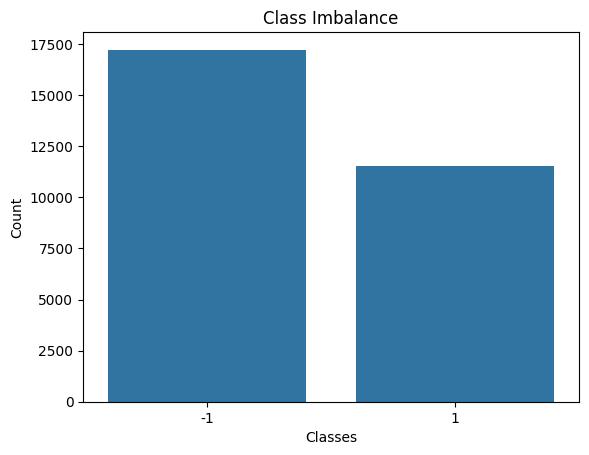

17220   11548
outcome
-1    17220
 1    17220
Name: count, dtype: int64


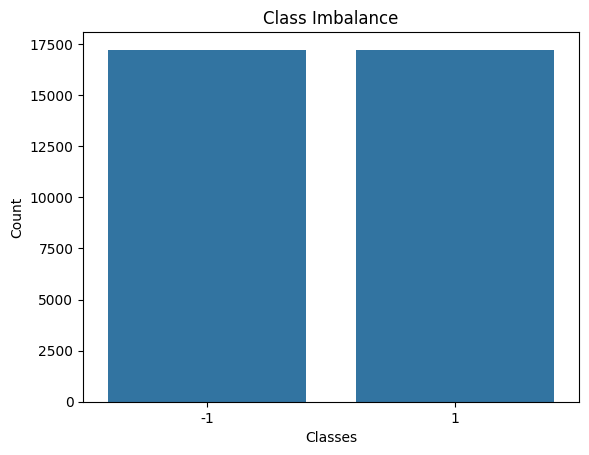

(34440, 53)

In [44]:
dataset_2015 = handle_class_imbalance(dataset_2015)
dataset_2015.shape

In [45]:
dataset_2015, player_name_mapping_2015 = player_name_encoding(dataset_2015)
dataset_2015.shape
player_name_mapping_2015

{'A.J. Price': 0,
 'Aaron Brooks': 1,
 'Aaron Gordon': 2,
 'Adreian Payne': 3,
 'Al Horford': 4,
 'Al Jefferson': 5,
 'Al-Farouq Aminu': 6,
 'Alan Anderson': 7,
 'Alec Burks': 8,
 'Alex Kirk': 9,
 'Alex Len': 10,
 'Alexey Shved': 11,
 'Alexis Ajinca': 12,
 'Allen Crabbe': 13,
 'Alonzo Gee': 14,
 "Amar'e Stoudemire": 15,
 'Amir Johnson': 16,
 'Anderson Varejao': 17,
 'Andre Dawkins': 18,
 'Andre Drummond': 19,
 'Andre Iguodala': 20,
 'Andre Miller': 21,
 'Andre Roberson': 22,
 'Andrea Bargnani': 23,
 'Andrei Kirilenko': 24,
 'Andrew Bogut': 25,
 'Andrew Nicholson': 26,
 'Andrew Wiggins': 27,
 'Anthony Bennett': 28,
 'Anthony Davis': 29,
 'Anthony Morrow': 30,
 'Anthony Tolliver': 31,
 'Archie Goodwin': 32,
 'Arinze Onuaku': 33,
 'Aron Baynes': 34,
 'Arron Afflalo': 35,
 'Austin Daye': 36,
 'Austin Rivers': 37,
 'Avery Bradley': 38,
 'Ben Gordon': 39,
 'Ben McLemore': 40,
 'Beno Udrih': 41,
 'Bernard James': 42,
 'Bismack Biyombo': 43,
 'Blake Griffin': 44,
 'Bojan Bogdanovic': 45,
 'Bor

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              3.664344
3p_pct_home             41.893148
ftm_home                 0.000000
ft_pct_home             60.963995
ts_pct_home              1.686992
ast_to_ratio_home       58.925668
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


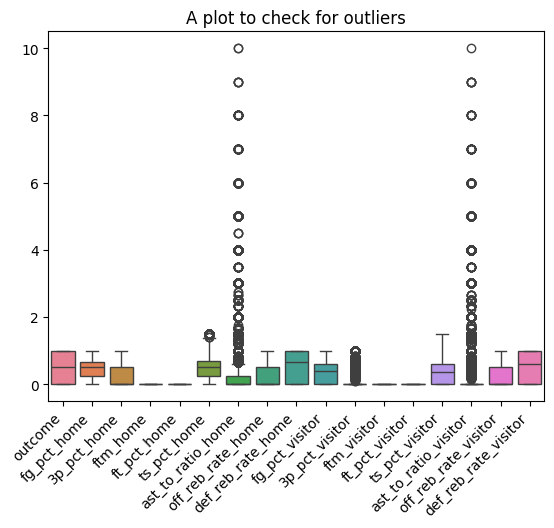

(34440, 40)

In [46]:
dataset_2015 = feature_engineering(dataset_2015)
dataset_2015.shape

In [47]:
X_home_2015, X_away_2015, X_stats_2015, y_2015 = data_transformation(dataset_2015)

In [48]:
embedding_model_2015 = generate_player_embedding(X_home_2015, X_away_2015, X_stats_2015, y_2015, player_name_mapping_2015)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     19,648 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     19,648 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 336)       │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     10,784 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,113 (195.75 KB)

 Trainable params: 50,113 (195.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7976 - loss: 0.4441 - val_accuracy: 0.8175 - val_loss: 0.3935 - learning_rate: 0.0010
Epoch 2/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8926 - loss: 0.2567 - val_accuracy: 0.8566 - val_loss: 0.3211 - learning_rate: 0.0010
Epoch 3/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9194 - loss: 0.2038 - val_accuracy: 0.8518 - val_loss: 0.3263 - learning_rate: 0.0010
Epoch 4/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9334 - loss: 0.1693 - val_accuracy: 0.8827 - val_loss: 0.2747 - learning_rate: 0.0010
Epoch 5/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9443 - loss: 0.1411 - val_accuracy: 0.8863 - val_loss: 0.2817 - learning_rate: 0.0010
Epoch 6/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9587 - loss: 0.1156 - val_accuracy: 0.8875 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 7/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9677 - loss: 0.0971 - 

In [49]:
X_2015, y_2015 = map_player_embedding(dataset_2015, embedding_model_2015)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.57      0.58      3463
         1.0       0.58      0.59      0.59      3425

    accuracy                           0.58      6888
   macro avg       0.58      0.58      0.58      6888
weighted avg       0.58      0.58      0.58      6888



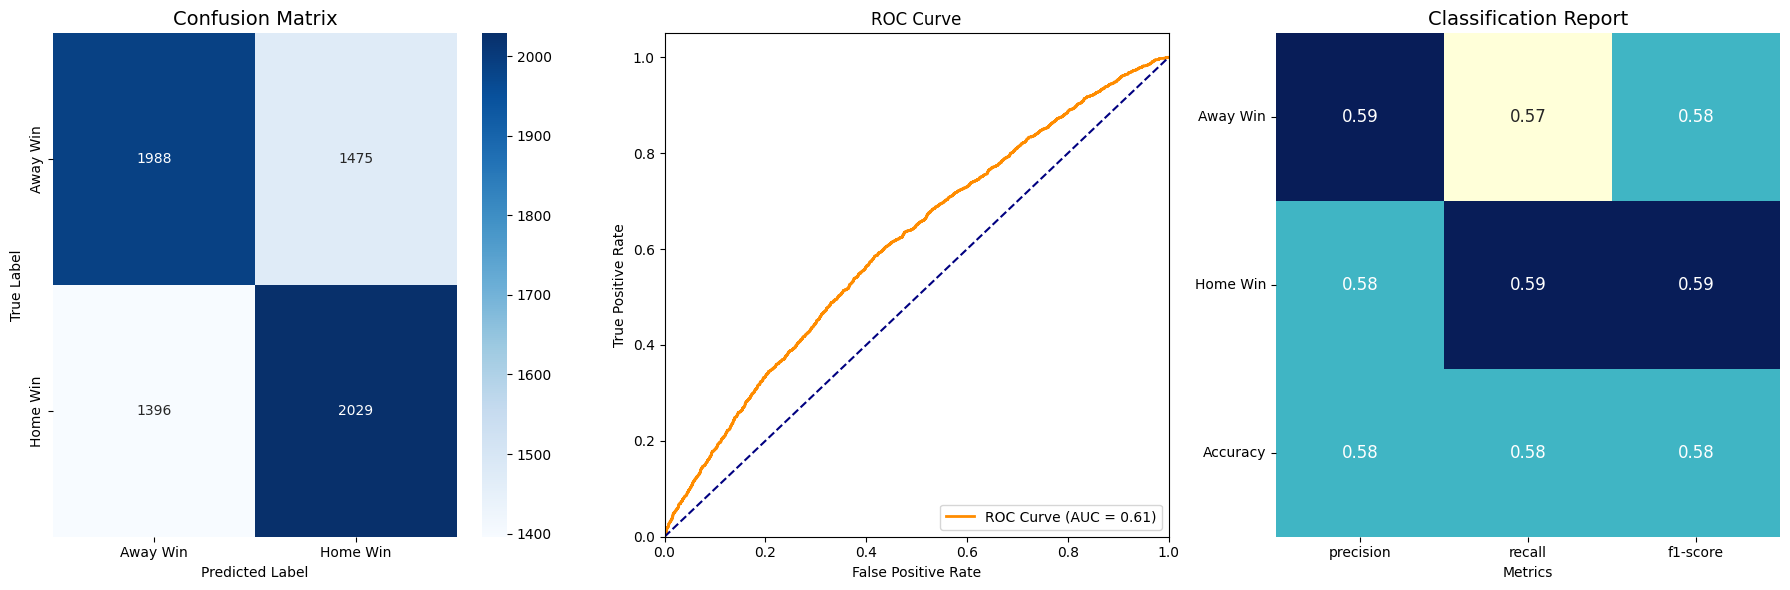

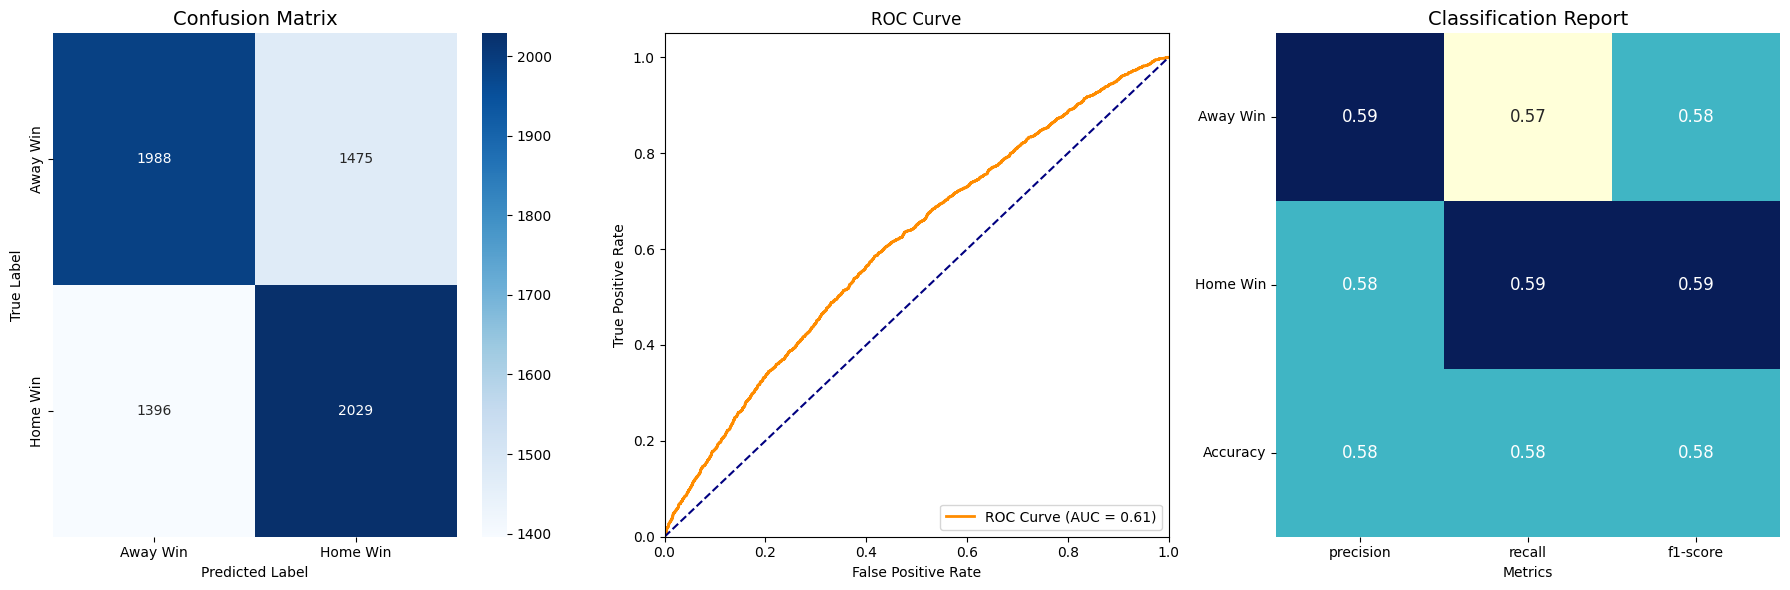

In [50]:
# Logistic Regression
X_train_lr_2015, X_test_lr_2015, y_train_lr_2015, y_test_lr_2015 = split_lr_train_test_data(X_2015, y_2015)
lr_model_2015 = train_test_logistic_regression(X_train_lr_2015, y_train_lr_2015)
y_pred_lr_2015 = predict_logistic_regression(lr_model_2015, X_test_lr_2015)
generate_classification_report(y_test_lr_2015, y_pred_lr_2015)
plot_logistic_regression_model_diagnostics(lr_model_2015, X_test_lr_2015, y_test_lr_2015)


Training model...
Making predictions...

Accuracy: 0.5808652729384437

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.57      0.58      3444
         1.0       0.58      0.59      0.59      3444

    accuracy                           0.58      6888
   macro avg       0.58      0.58      0.58      6888
weighted avg       0.58      0.58      0.58      6888


Top 5 most important features:
Feature 32: 0.0736
Feature 270: 0.0532
Feature 278: 0.0464
Feature 131: 0.0442
Feature 161: 0.0407
Test Accuracy: 0.581

Top 5 Features:
Feature 32: 0.0736
Feature 270: 0.0532
Feature 278: 0.0464
Feature 131: 0.0442
Feature 161: 0.0407


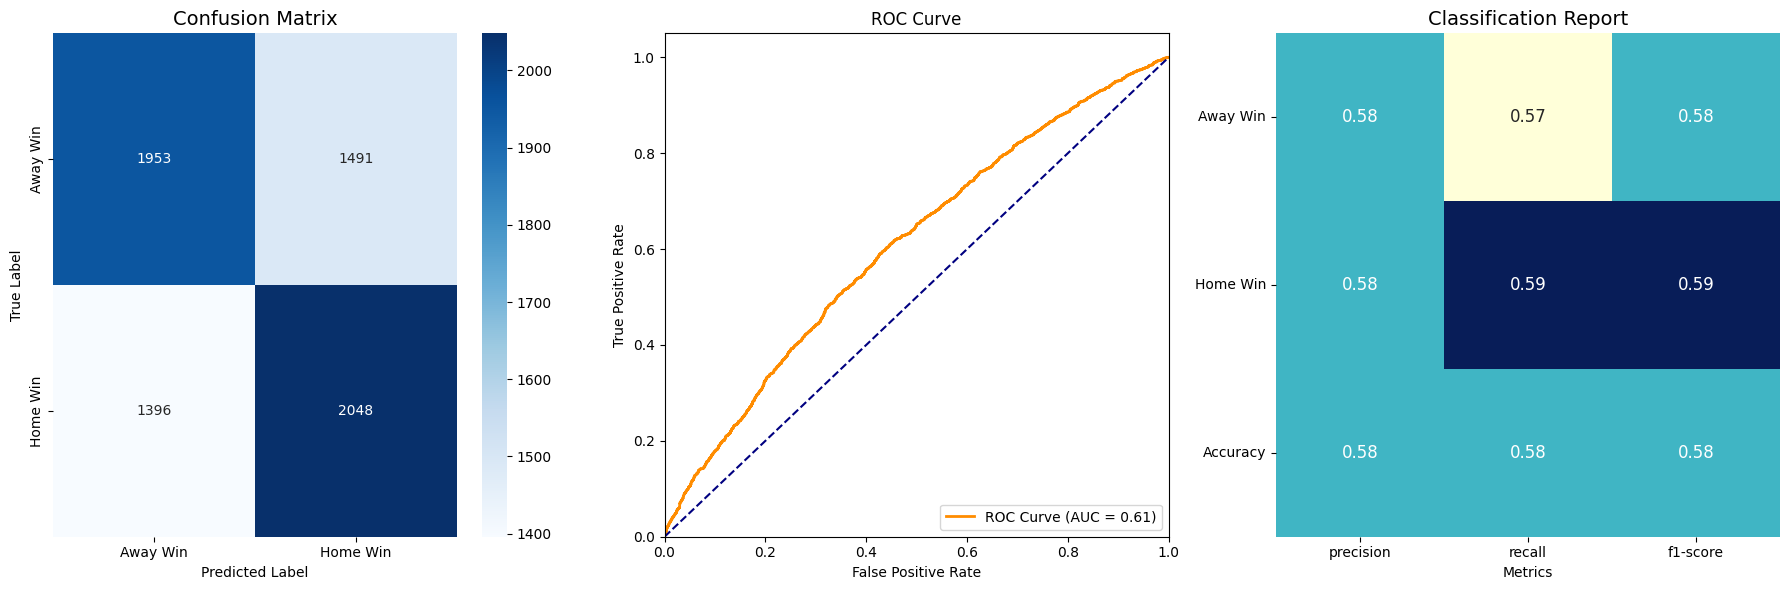

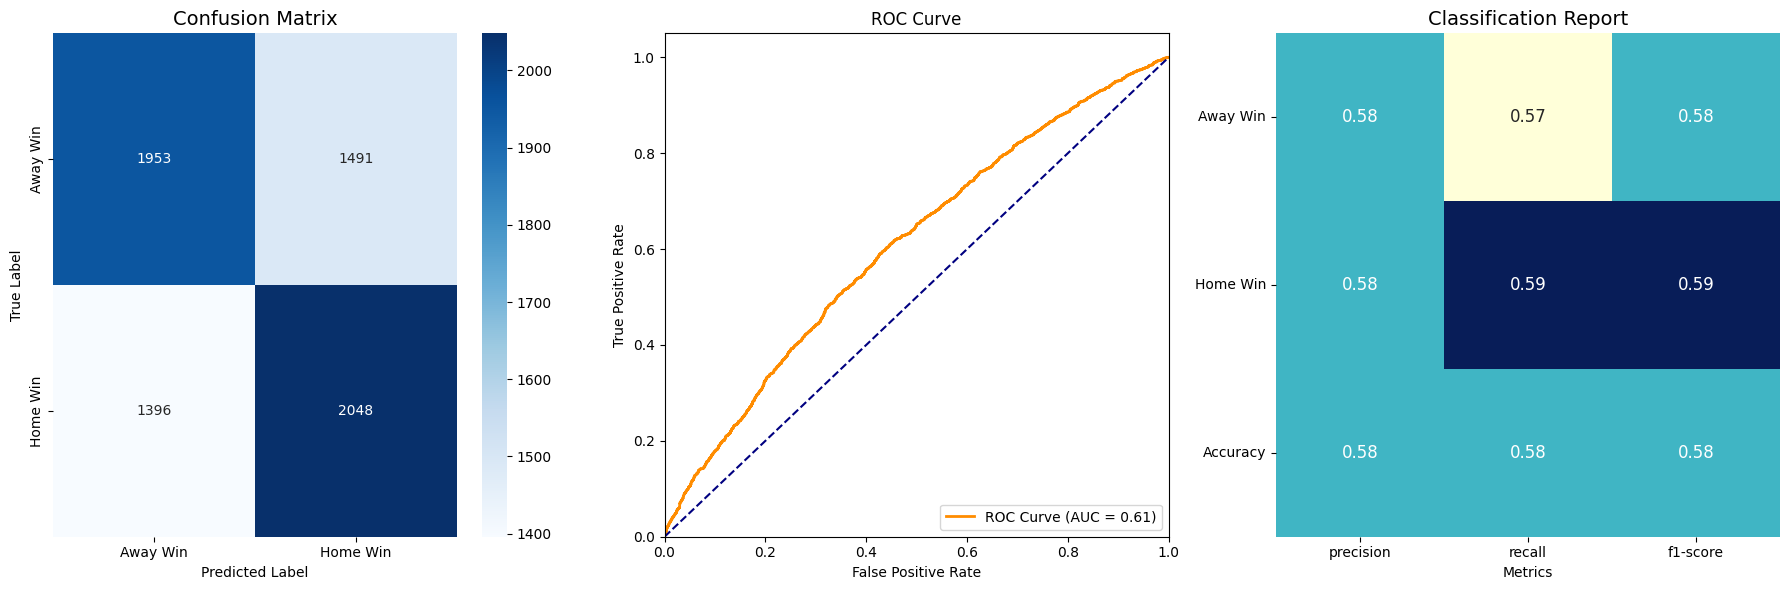

In [51]:
# Support Vector Machine
X_train_svm_2015, X_test_svm_2015, y_train_svm_2015, y_test_svm_2015 = split_svm_train_test_data(X_2015, y_2015)
svm_model_2015 = train_support_vector_machines(X_train_svm_2015, y_train_svm_2015)
y_pred_svm_2015 = predict_svm(svm_model_2015, X_test_svm_2015)
view_svm_results(svm_model_2015, y_test_svm_2015, y_pred_svm_2015)
plot_svm_diagnostics(svm_model_2015, X_test_svm_2015, y_test_svm_2015)


Epoch 1/100


C:\Users\sahil\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/431 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5210 - loss: 0.8261
Epoch 1: val_accuracy improved from -inf to 0.57056, saving model to best_model.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5211 - loss: 0.8256 - val_accuracy: 0.5706 - val_loss: 0.6802 - learning_rate: 5.0000e-04
Epoch 2/100
429/431 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5597 - loss: 0.7062
Epoch 2: val_accuracy improved from 0.57056 to 0.58885, saving model to best_model.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5597 - loss: 0.7061 - val_accuracy: 0.5889 - val_loss: 0.6701 - learning_rate: 5.0000e-04
Epoch 3/100
429/431 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5831 - loss: 0.6807
Epoch 3: val_accuracy improved from 0.58885 to 0.59930, saving model to best_model.keras
431/431 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.5831 - loss: 0.6807 - val_accuracy: 0.5993 - val_loss: 0.6624 - learning_rate: 5.0000e-04
Epoch 4/100
426/431 ━━━━━━━━━━━━━━━━━━━━ 0s 1

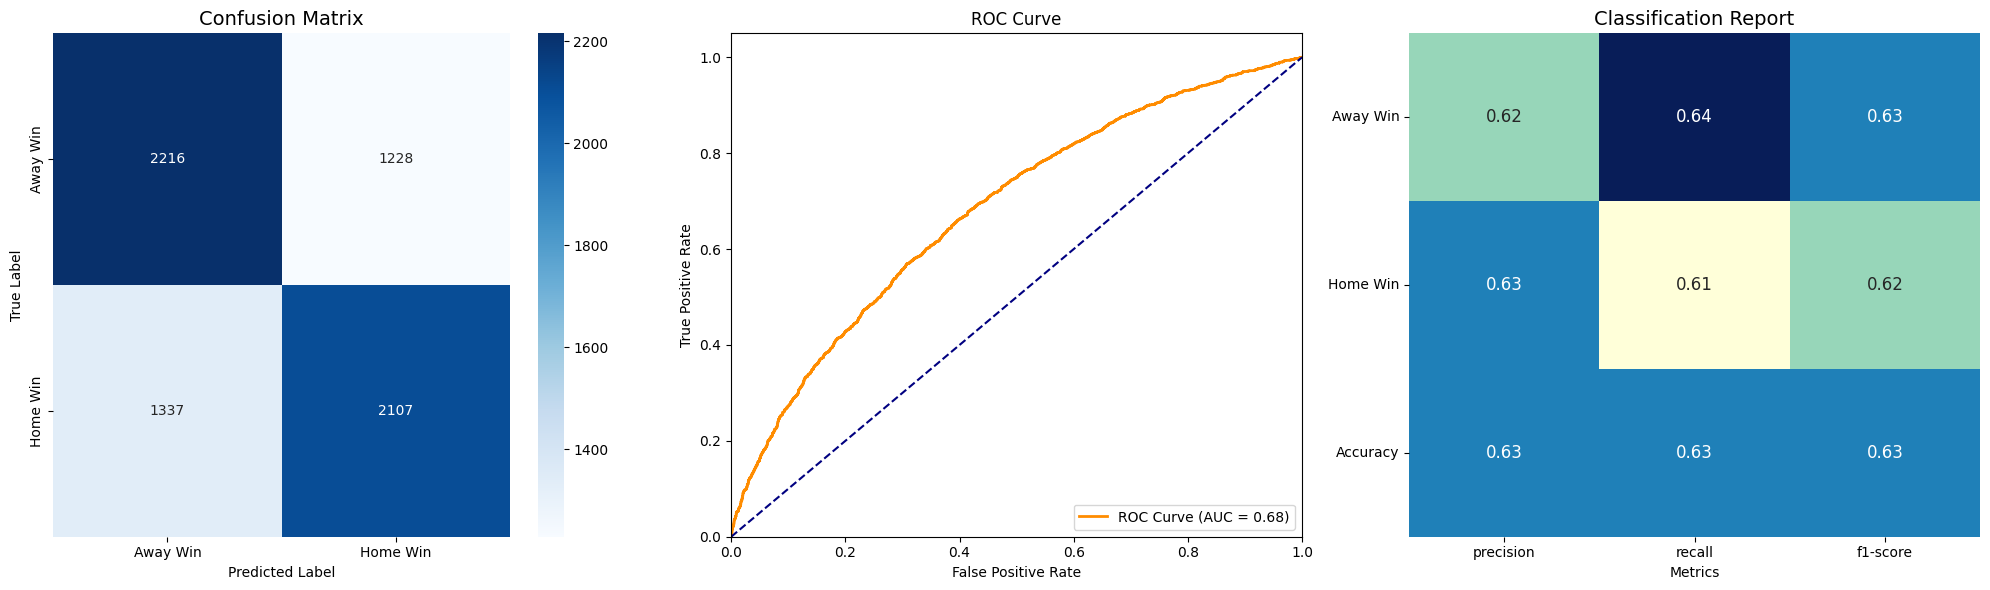

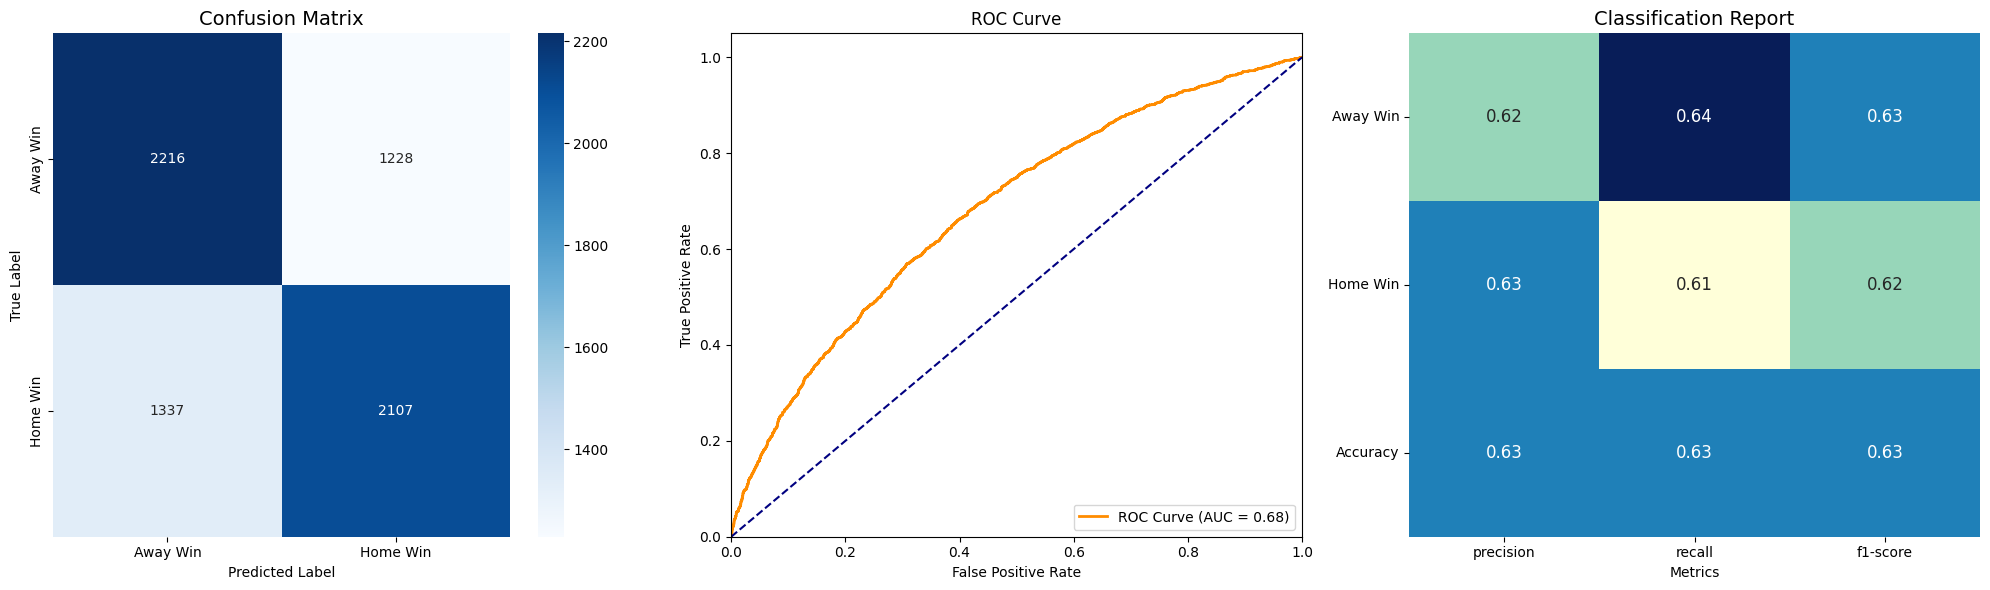

In [52]:
# Neural Networks
X_train_nn_2015, X_test_nn_2015, y_train_nn_2015, y_test_nn_2015 = split_nn_train_test_data(X_2015, y_2015)
nn_model_2015 = train_neural_network_model(X_train_nn_2015, X_test_nn_2015, y_train_nn_2015, y_test_nn_2015)
y_pred_nn_2015, y_pred_classes_nn_2015 = predict_neural_network_model(nn_model_2015, X_test_nn_2015)
evaluate_nn_metrics(y_test_nn_2015, y_pred_nn_2015, y_pred_classes_nn_2015)
plot_nn_diagnostics(nn_model_2015, X_test_nn_2015, y_test_nn_2015)


Applying PCA...
Reduced dimensions from 320 to 205 features
Accuracy: 0.7738095238095238

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      3444
         1.0       0.79      0.75      0.77      3444

    accuracy                           0.77      6888
   macro avg       0.77      0.77      0.77      6888
weighted avg       0.77      0.77      0.77      6888


Top 5 most important features:
Feature 14: 0.0114
Feature 1: 0.0092
Feature 8: 0.0080
Feature 22: 0.0069
Feature 19: 0.0068
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.80      0.78      3444
         1.0       0.79      0.75      0.77      3444

    accuracy                           0.77      6888
   macro avg       0.77      0.77      0.77      6888
weighted avg       0.77      0.77      0.77      6888



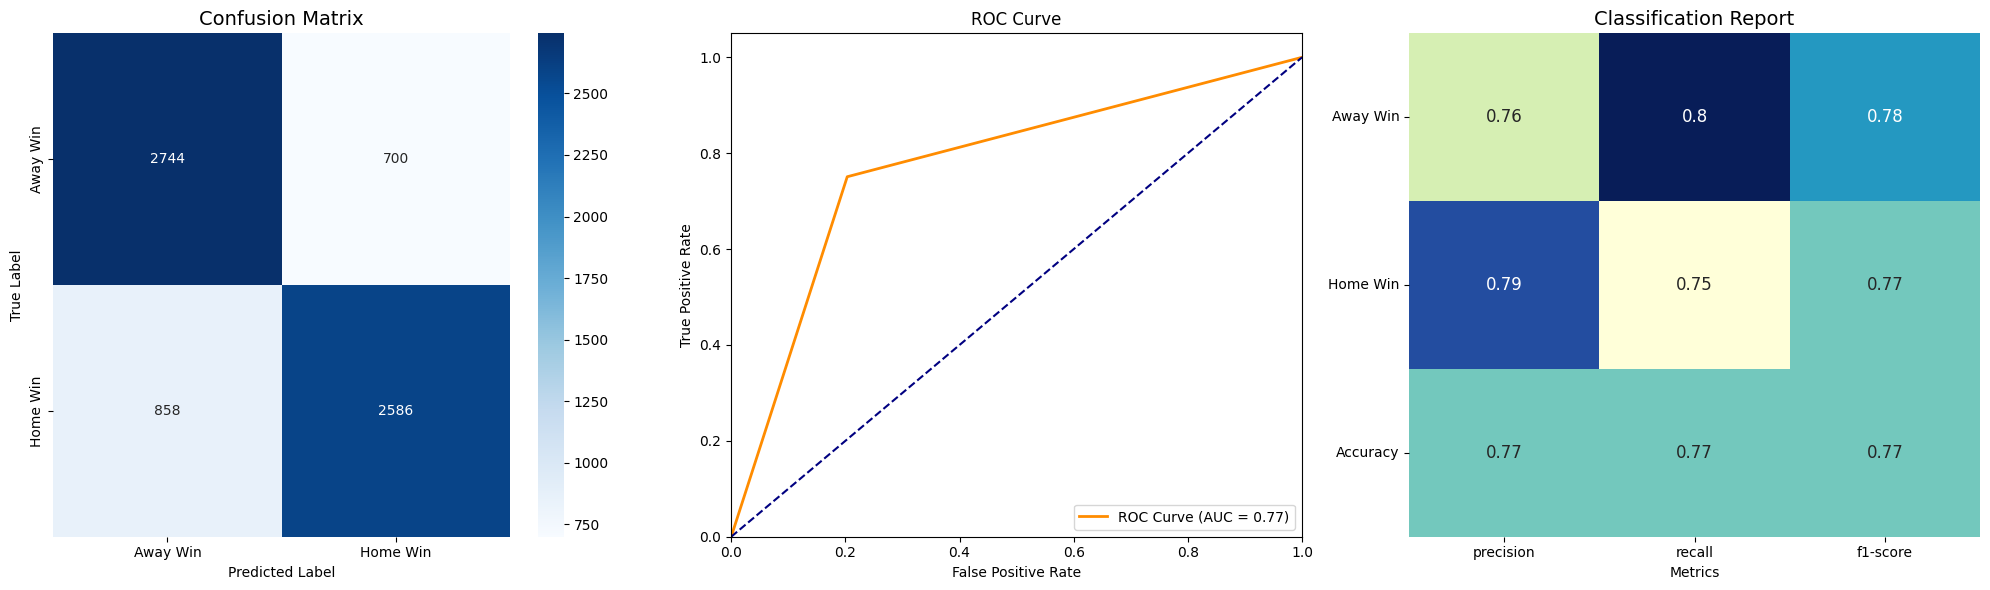

In [53]:
# Random Forests
X_train_rf_2015, X_test_rf_2015, y_train_rf_2015, y_test_rf_2015, rf_scaler_2015, rf_pca_2015 = split_random_forest_train_test_data(X_2015, y_2015)
rf_model_2015 = train_random_forest_model(X_train_rf_2015, y_train_rf_2015)
y_pred_rf_2015 = predict_random_forest_model(rf_model_2015, X_test_rf_2015)
evaluate_random_forest_model(rf_model_2015, y_test_rf_2015, y_pred_rf_2015)
plot_rf_diagnostics(rf_model_2015, X_test_rf_2015, y_test_rf_2015)


Scaling features...
Applying PCA...
Reduced dimensions from 320 to 205 features

Performing cross-validation...
Cross-validation scores: [0.64329268 0.6511324  0.63403746]
Mean CV accuracy: 0.643 (+/- 0.014)

Training final model...

Model Evaluation:
Accuracy: 0.6948315911730546

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.57      0.65      3444
         1.0       0.66      0.82      0.73      3444

    accuracy                           0.69      6888
   macro avg       0.71      0.69      0.69      6888
weighted avg       0.71      0.69      0.69      6888


Prediction Confidence Analysis:
Mean confidence: 0.840
Min confidence: 0.500
Max confidence: 1.000


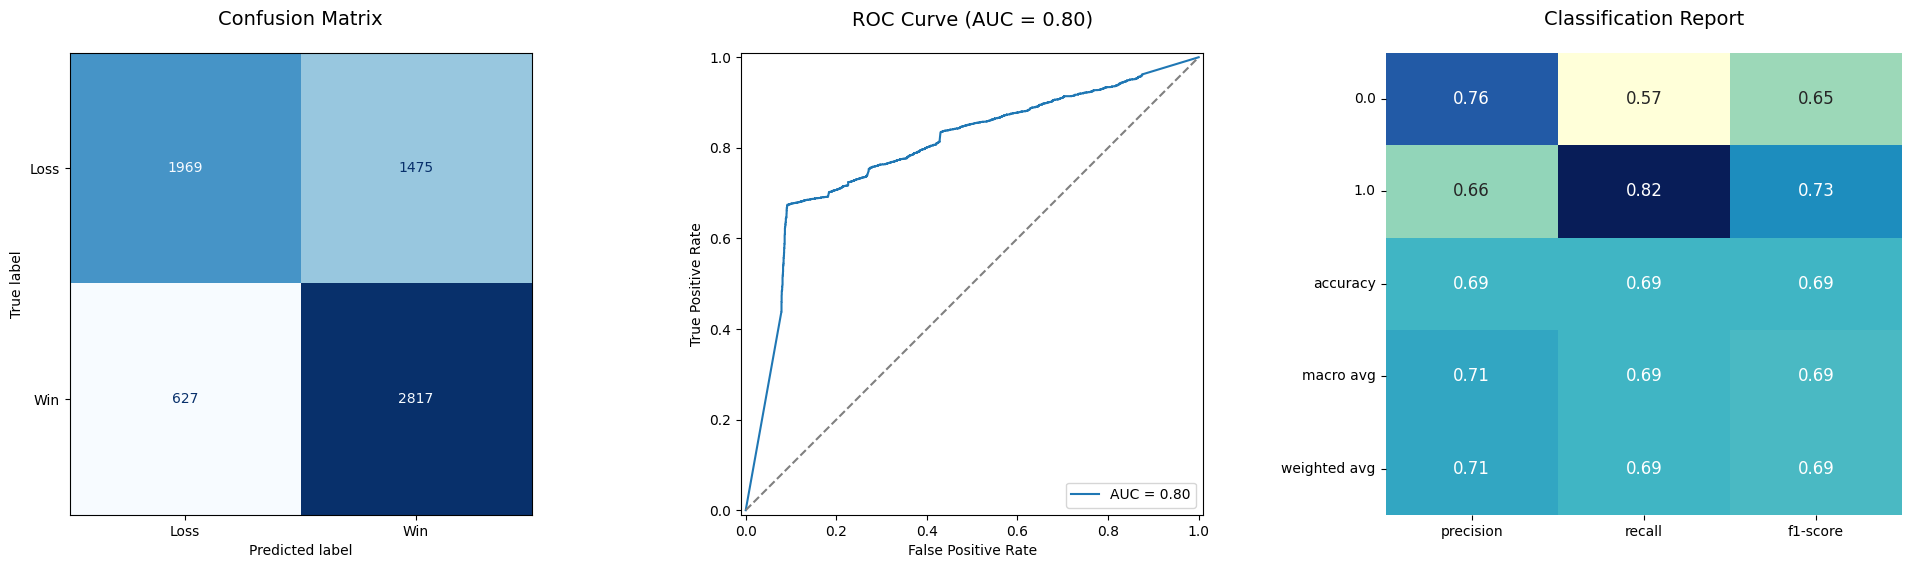

In [54]:
# K Nearest Neighbor
X_train_knn_2015, X_test_knn_2015, y_train_knn_2015, y_test_knn_2015, knn_scaler_2015, knn_pca_2015 = split_knn_train_test_data(X_2015, y_2015)
knn_model_2015 = train_knn_model(X_train_knn_2015, y_train_knn_2015)
y_pred_knn_2015, y_proba_knn_2015 = predict_knn_model(knn_model_2015, X_test_knn_2015)
evaluate_knn_model(knn_model_2015, y_test_knn_2015, y_pred_knn_2015, y_proba_knn_2015)
plot_knn_diagnostics(knn_model_2015, X_test_knn_2015, y_test_knn_2015)


In [55]:
# Load dataset chunks year by year
# each dataset will be  loaded with current year + 2 preceding years
def generate_datasets(start_year, end_year):
    datasets = {}
    for year in range(start_year, end_year):
        print("Dataset Year: ", year)
        raw_dataset = preprocess_dataset_by_year(year)
        raw_dataset = handle_class_imbalance(raw_dataset)
        players_list_by_season_and_team = get_players_list_by_season_and_team(raw_dataset)
        raw_dataset, player_name_mapping = player_name_encoding(raw_dataset)
        raw_dataset = feature_engineering(raw_dataset)
        datasets[year] = {'dataset': raw_dataset, 'players_mappings': player_name_mapping, 'players_list_by_season': players_list_by_season_and_team}
    return datasets

In [56]:
# Generate models for Random Forests using year-on-year datasets
def generate_random_forest_model(X, y):
    # Random Forests
    X_train_rf, X_test_rf, y_train_rf, y_test_rf, scaler, pca = split_random_forest_train_test_data(X, y)
    rf_model = train_random_forest_model(X_train_rf, y_train_rf)
    y_pred_rf = predict_random_forest_model(rf_model, X_test_rf)
    evaluate_random_forest_model(rf_model, y_test_rf, y_pred_rf)
    plot_rf_diagnostics(rf_model, X_test_rf, y_test_rf)
    return rf_model, scaler, pca

In [57]:
# Generate models for KNN using year-on-year datasets
def generate_knn_model(X, y):
    X_train_knn, X_test_knn, y_train_knn, y_test_knn, scalar, pca = split_knn_train_test_data(X, y)
    knn_model = train_knn_model(X_train_knn, y_train_knn)
    y_pred_knn, y_proba_knn = predict_knn_model(knn_model, X_test_knn)
    evaluate_knn_model(knn_model, y_test_knn, y_pred_knn, y_proba_knn)
    plot_knn_diagnostics(knn_model, X_test_knn, y_test_knn)
    return knn_model, scalar, pca

In [58]:
# Generate a dictionary of models for both Random forests and knn
def generate_models(datasets):
    models = {}
    for year in datasets:
        X_home, X_away, X_stats, y = data_transformation(datasets[year]['dataset'])
        embedding_model = generate_player_embedding(X_home, X_away, X_stats, y, datasets[year]['players_mappings'])
        X, y = map_player_embedding(datasets[year]['dataset'], embedding_model)
        rf_model, rf_scaler, rf_pca = generate_random_forest_model(X, y)
        knn_model, knn_scalar, knn_pca = generate_knn_model(X, y)
        models[year] = {'embedding_model': embedding_model, 'random_forest': [rf_model, rf_scaler, knn_pca], 'knn': [knn_model, knn_scalar, knn_pca]}
    return models

In [59]:
# Code to save the generated models
def save_generated_models(models, datasets):
    for year in models:
        joblib.dump(models[year]['embedding_model'], 'models/player_embeddings/player_embeddings_' + str(year) + '.pkl')
        joblib.dump(models[year]['random_forest'][0], 'models/random_forest/rf_model_' + str(year) + '.pkl')
        joblib.dump(models[year]['random_forest'][1], 'models/random_forest/rf_scalar_' + str(year) + '.pkl')
        joblib.dump(models[year]['random_forest'][2], 'models/random_forest/rf_pca_' + str(year) + '.pkl')
        joblib.dump(models[year]['knn'][0], 'models/knn/knn_model_' + str(year) + '.pkl')
        joblib.dump(models[year]['knn'][1], 'models/knn/knn_scalar_' + str(year) + '.pkl')
        joblib.dump(models[year]['knn'][2], 'models/knn/knn_pca_' + str(year) + '.pkl')
        player_list = json.dumps(datasets[year]['players_list_by_season'], indent = 4)
        with open('models/players_list_by_model/player_list_' + str(year) + '.json', 'w') as outfile:
            outfile.write(player_list)
        player_mapping = json.dumps(datasets[year]['players_mappings'], indent = 4)
        with open('models/player_mappings/player_mapping_' + str(year) + '.json', 'w') as outfile:
            outfile.write(player_mapping)


In [60]:
# Code to Load the saved models
def load_generated_models():
    start_year = 2007
    end_year = 2016
    models = {}
    for year in range(start_year, end_year):
        models[year] = {'random_forest': joblib.load('models/random_forest/rf_model_' + str(year) + '.pkl'), 'knn': 'models/knn/knn_model_' + str(year) + '.pkl'}
    return models


Dataset Year:  2007


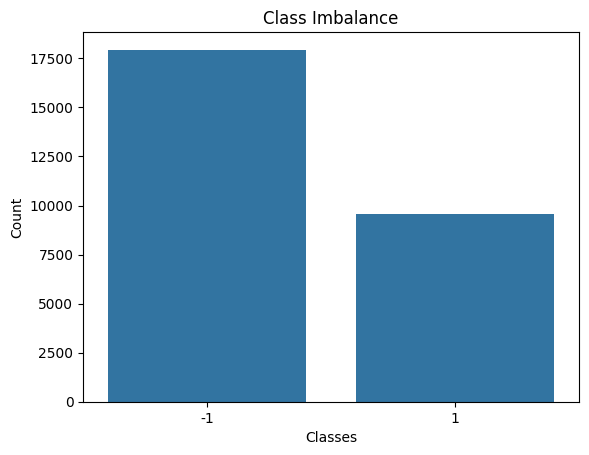

17942   9558
outcome
-1    17942
 1    17942
Name: count, dtype: int64


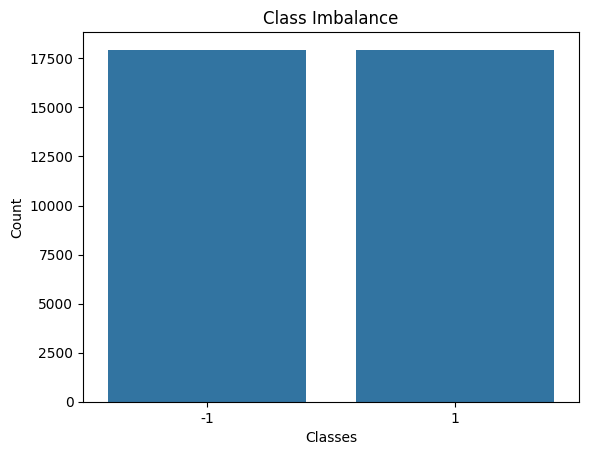

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             13.579868
3p_pct_home             54.570282
ftm_home                 0.000000
ft_pct_home             59.341211
ts_pct_home             11.573403
ast_to_ratio_home       61.280794
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


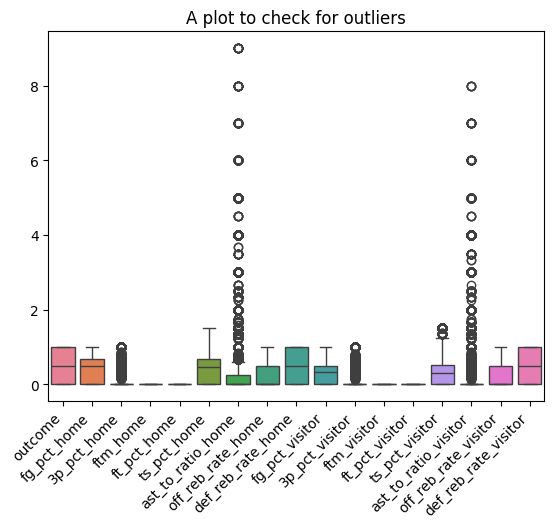

Dataset Year:  2008


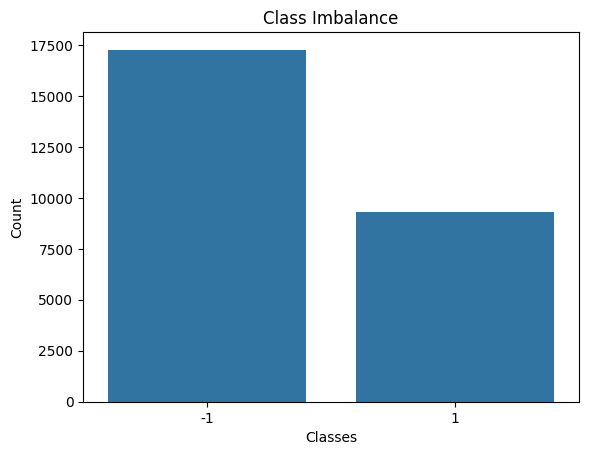

17265   9328
outcome
-1    17265
 1    17265
Name: count, dtype: int64


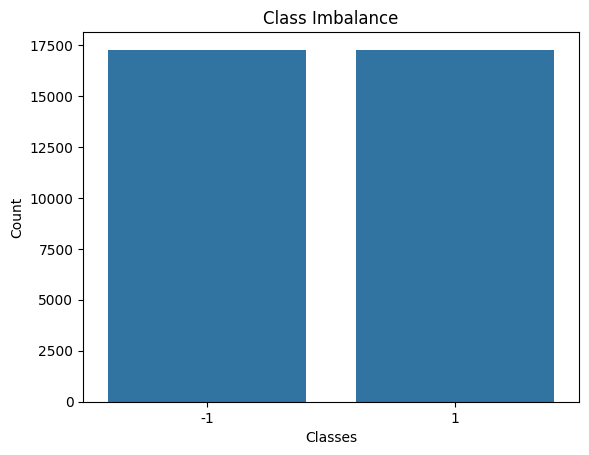

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             13.000290
3p_pct_home             51.424848
ftm_home                 0.000000
ft_pct_home             59.302056
ts_pct_home             11.364031
ast_to_ratio_home       62.363162
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


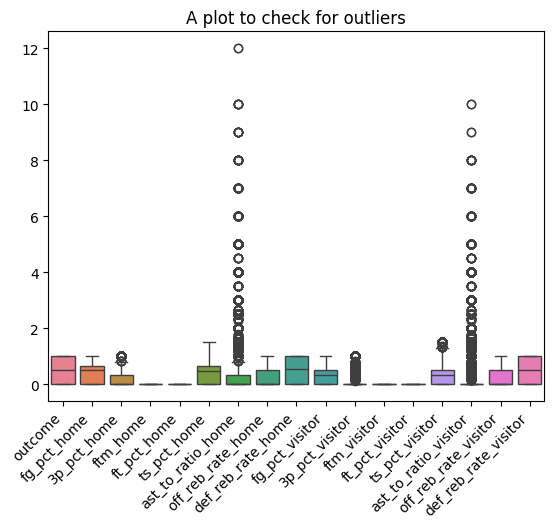

Dataset Year:  2009


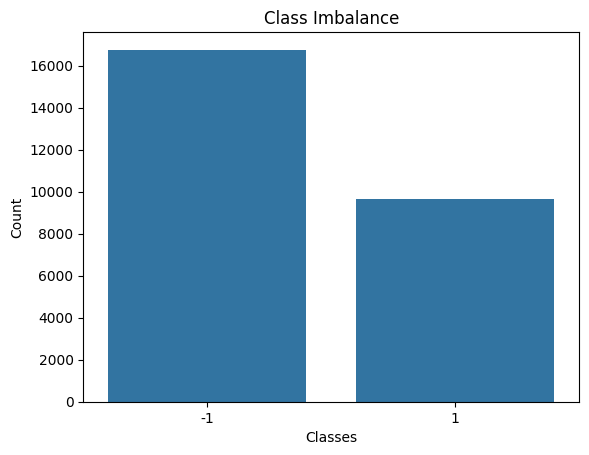

16751   9656
outcome
-1    16751
 1    16751
Name: count, dtype: int64


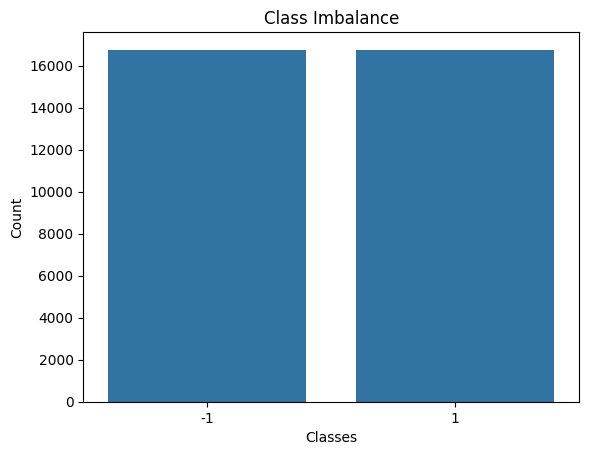

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.862038
3p_pct_home             50.432810
ftm_home                 0.000000
ft_pct_home             58.623366
ts_pct_home              9.199451
ast_to_ratio_home       61.554534
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


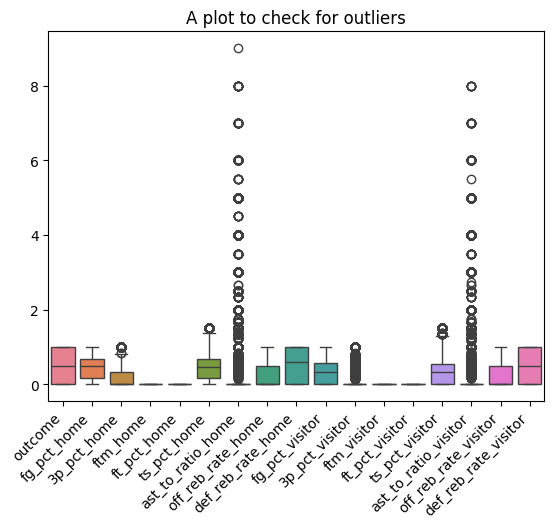

Dataset Year:  2010


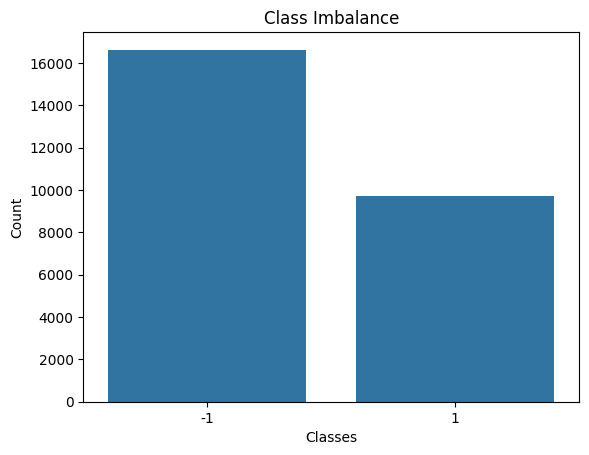

16623   9721
outcome
-1    16623
 1    16623
Name: count, dtype: int64


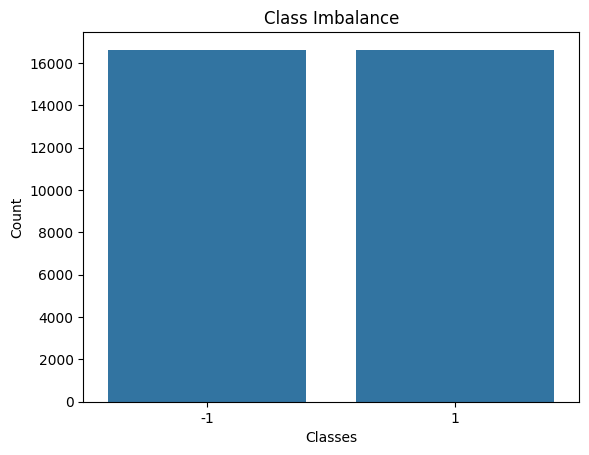

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.705047
3p_pct_home             50.562474
ftm_home                 0.000000
ft_pct_home             58.443121
ts_pct_home              8.984539
ast_to_ratio_home       61.174277
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


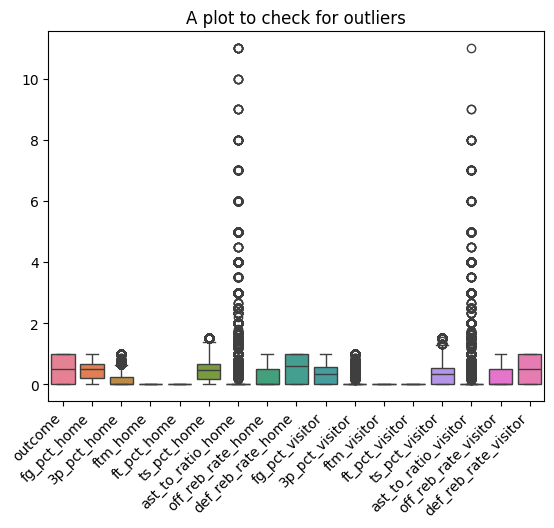

Dataset Year:  2011


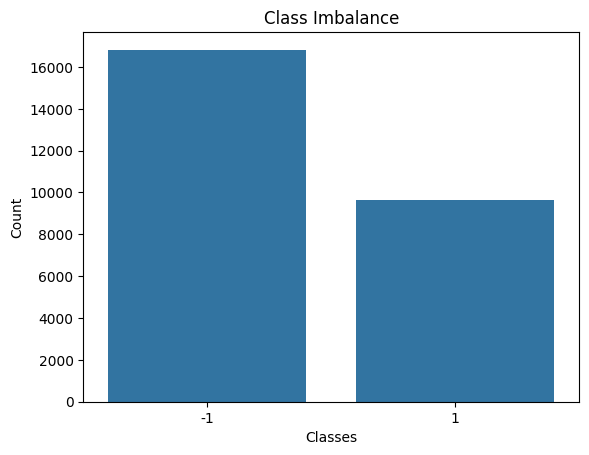

16824   9623
outcome
-1    16824
 1    16824
Name: count, dtype: int64


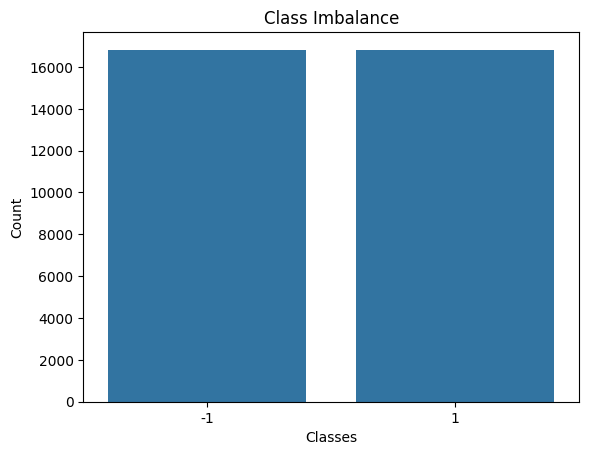

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.808963
3p_pct_home             49.732525
ftm_home                 0.000000
ft_pct_home             59.117927
ts_pct_home              9.201141
ast_to_ratio_home       60.886234
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


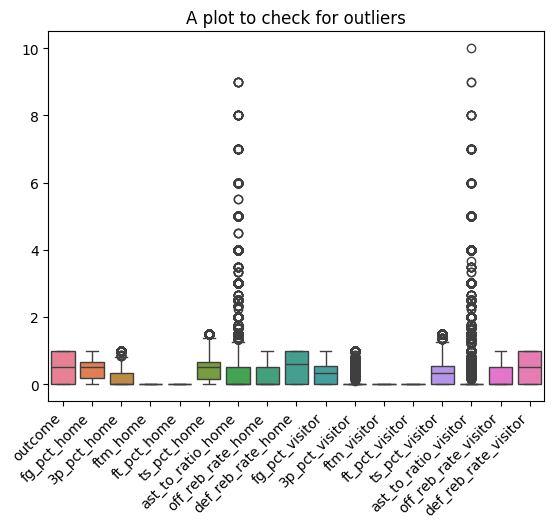

Dataset Year:  2012


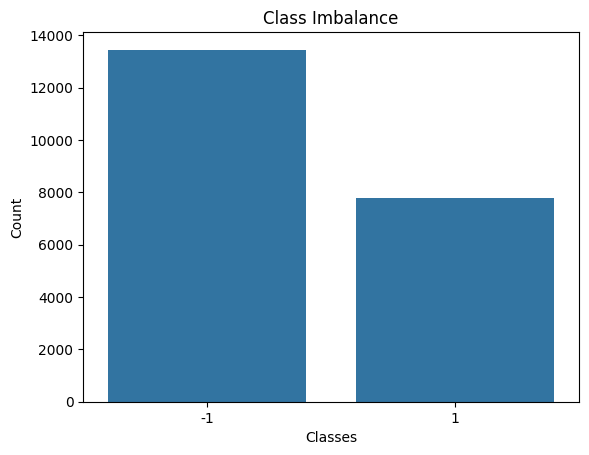

13454   7787
outcome
-1    13454
 1    13454
Name: count, dtype: int64


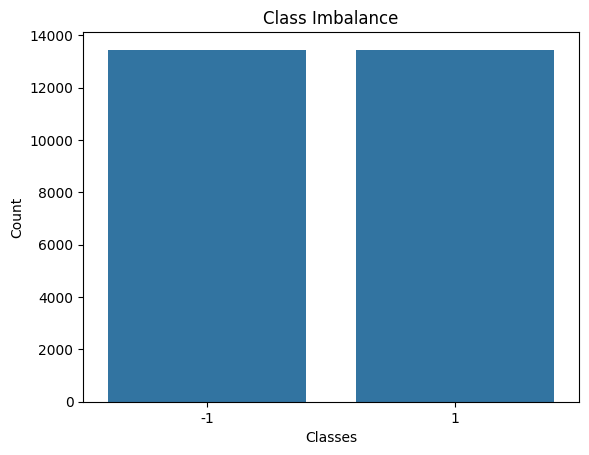

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home             10.937268
3p_pct_home             49.773302
ftm_home                 0.000000
ft_pct_home             61.706556
ts_pct_home              9.394975
ast_to_ratio_home       60.409544
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


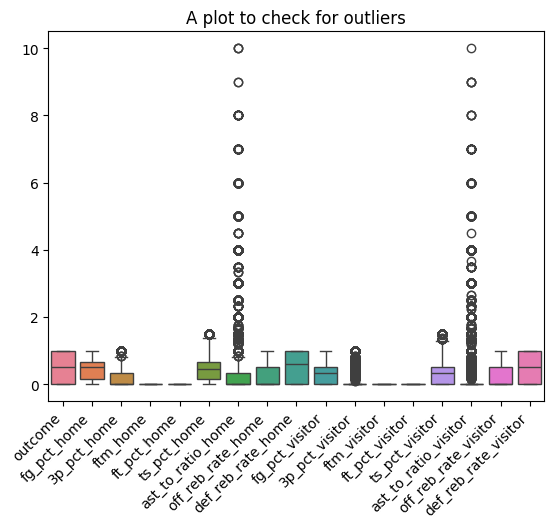

Dataset Year:  2013


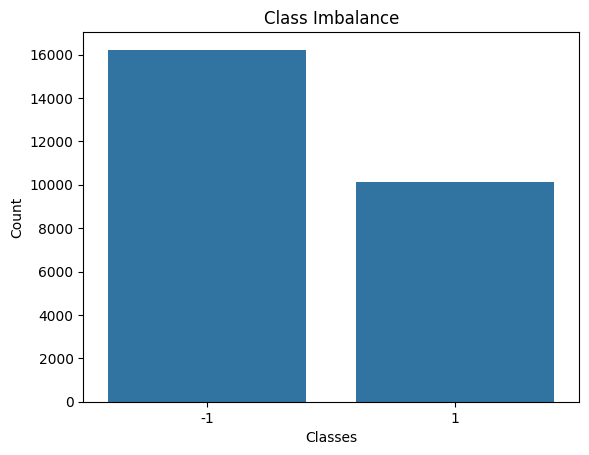

16221   10130
outcome
-1    16221
 1    16221
Name: count, dtype: int64


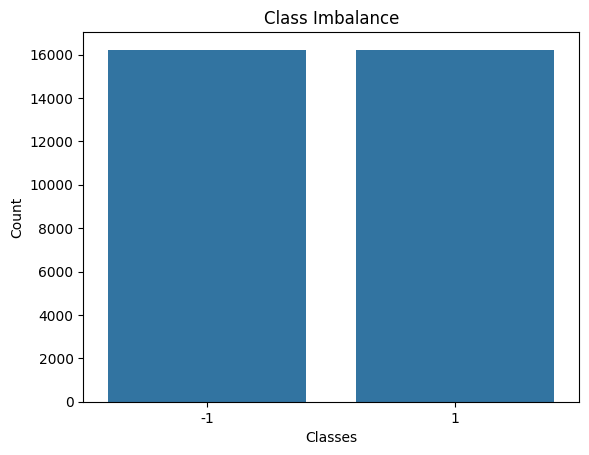

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              8.532150
3p_pct_home             46.331915
ftm_home                 0.000000
ft_pct_home             61.087479
ts_pct_home              6.947784
ast_to_ratio_home       59.083904
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


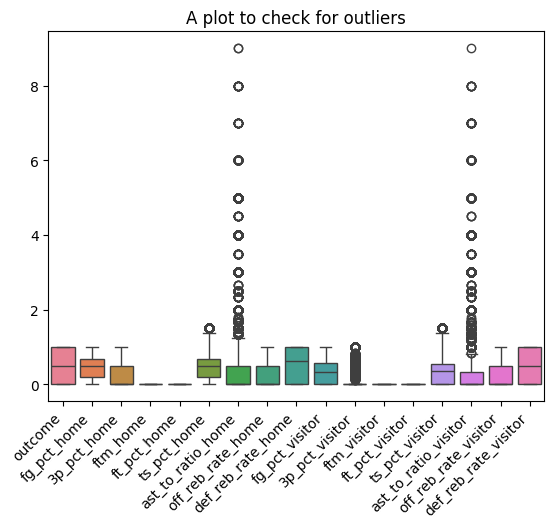

Dataset Year:  2014


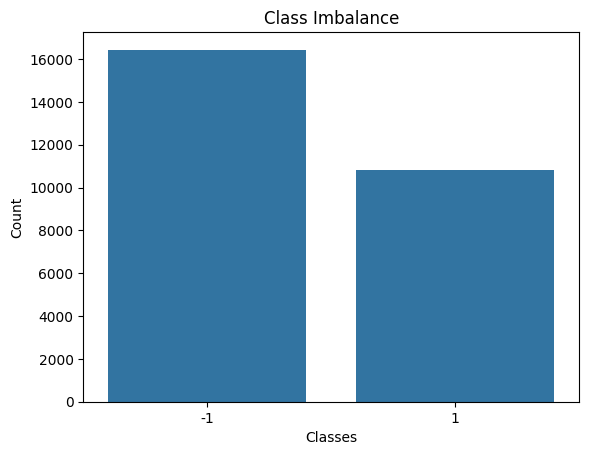

16437   10824
outcome
-1    16437
 1    16437
Name: count, dtype: int64


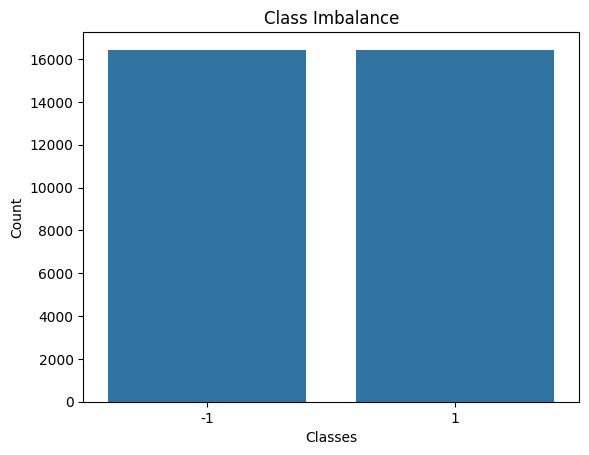

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              5.816146
3p_pct_home             43.642392
ftm_home                 0.000000
ft_pct_home             59.055789
ts_pct_home              4.051834
ast_to_ratio_home       57.972866
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


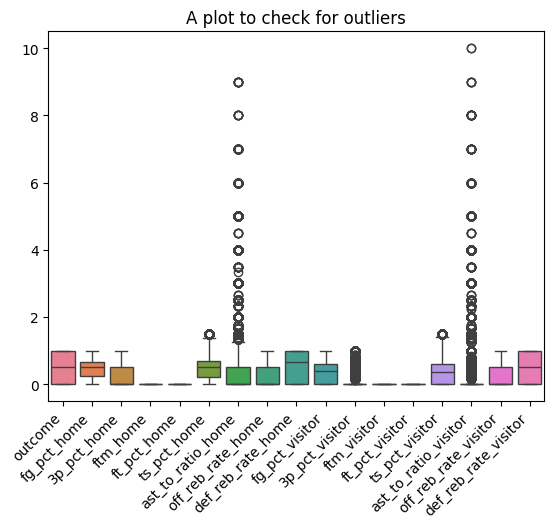

Dataset Year:  2015


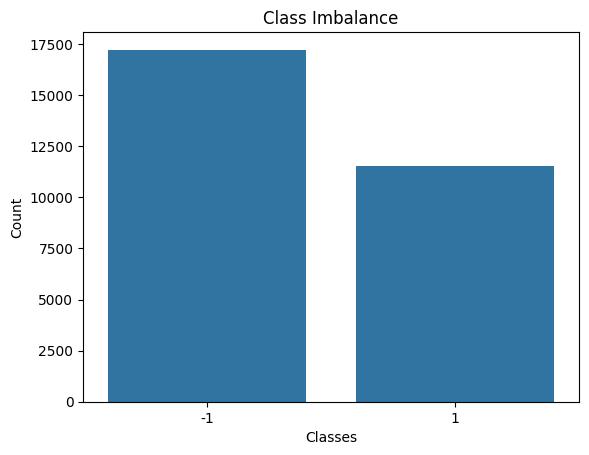

17220   11548
outcome
-1    17220
 1    17220
Name: count, dtype: int64


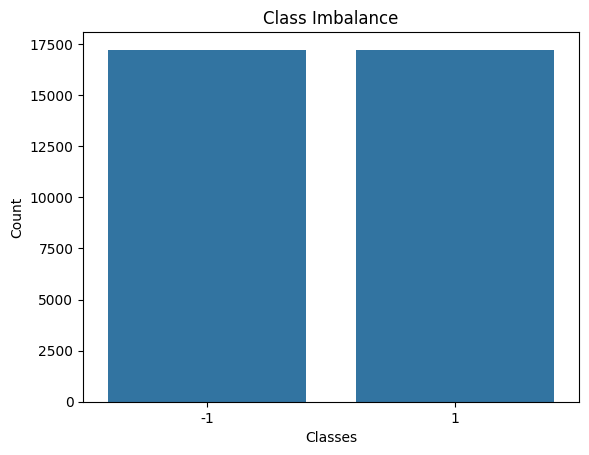

Percentage of null values for each column:
season                   0.000000
home_team                0.000000
away_team                0.000000
home_0                   0.000000
home_1                   0.000000
home_2                   0.000000
home_3                   0.000000
home_4                   0.000000
away_0                   0.000000
away_1                   0.000000
away_2                   0.000000
away_3                   0.000000
away_4                   0.000000
pts_home                 0.000000
pct_home                 0.000000
pct_2_home               0.000000
pct_3_home               0.000000
pts_visitor              0.000000
pct_visitor              0.000000
pct_2_visitor            0.000000
pct_3_visitor            0.000000
outcome                  0.000000
fg_pct_home              3.664344
3p_pct_home             41.893148
ftm_home                 0.000000
ft_pct_home             60.963995
ts_pct_home              1.686992
ast_to_ratio_home       58.925668
off_r

C:\Users\sahil\AppData\Local\Temp\ipykernel_17080\2920071957.py:69: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


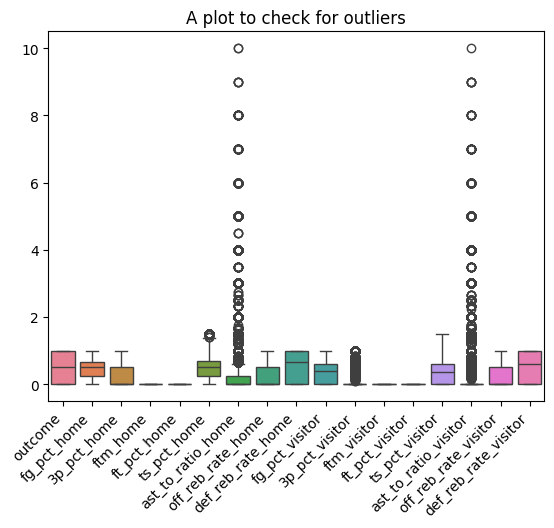

In [61]:
year_on_year_datasets = generate_datasets(2007, 2016)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,624 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,624 │ input_layer_5[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 336)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │     10,784 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,065 (187.75 KB)

 Trainable params: 48,065 (187.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8253 - loss: 0.4084 - val_accuracy: 0.8850 - val_loss: 0.2663 - learning_rate: 0.0010
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9040 - loss: 0.2256 - val_accuracy: 0.8930 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9225 - loss: 0.1843 - val_accuracy: 0.9066 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9391 - loss: 0.1545 - val_accuracy: 0.9257 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9488 - loss: 0.1295 - val_accuracy: 0.9020 - val_loss: 0.2424 - learning_rate: 0.0010
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9582 - loss: 0.1104 - val_accuracy: 0.9111 - val_loss: 0.2281 - learning_rate: 0.0010
Epoch 7/50
853/898 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9660 - loss: 0.0920
Ep

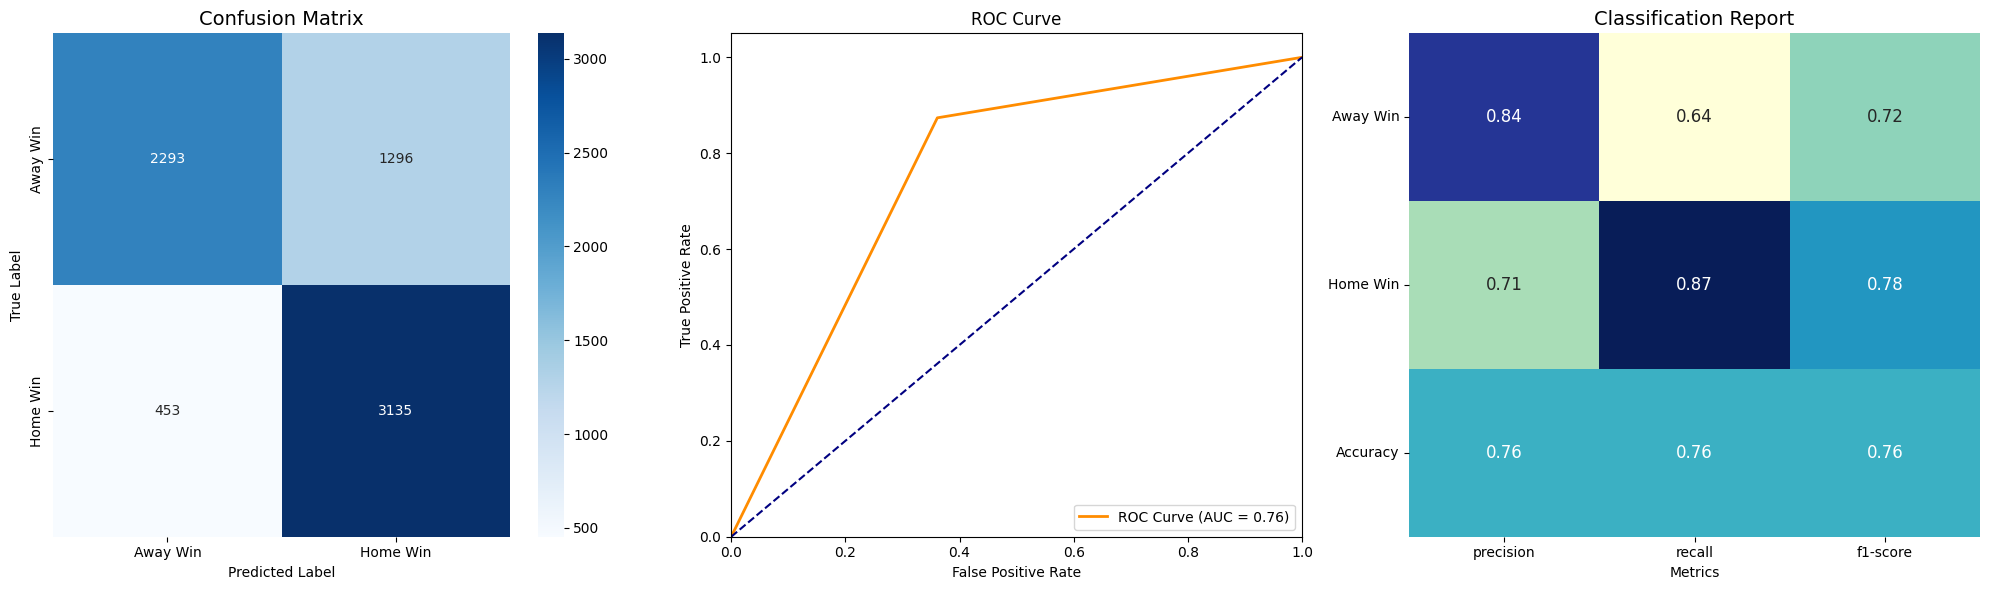

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 193 features

Performing cross-validation...
Cross-validation scores: [0.70811997 0.69829658 0.69463894]
Mean CV accuracy: 0.700 (+/- 0.011)

Training final model...

Model Evaluation:
Accuracy: 0.7379127769262923

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.60      0.70      3589
         1.0       0.69      0.87      0.77      3588

    accuracy                           0.74      7177
   macro avg       0.76      0.74      0.73      7177
weighted avg       0.76      0.74      0.73      7177


Prediction Confidence Analysis:
Mean confidence: 0.876
Min confidence: 0.500
Max confidence: 1.000


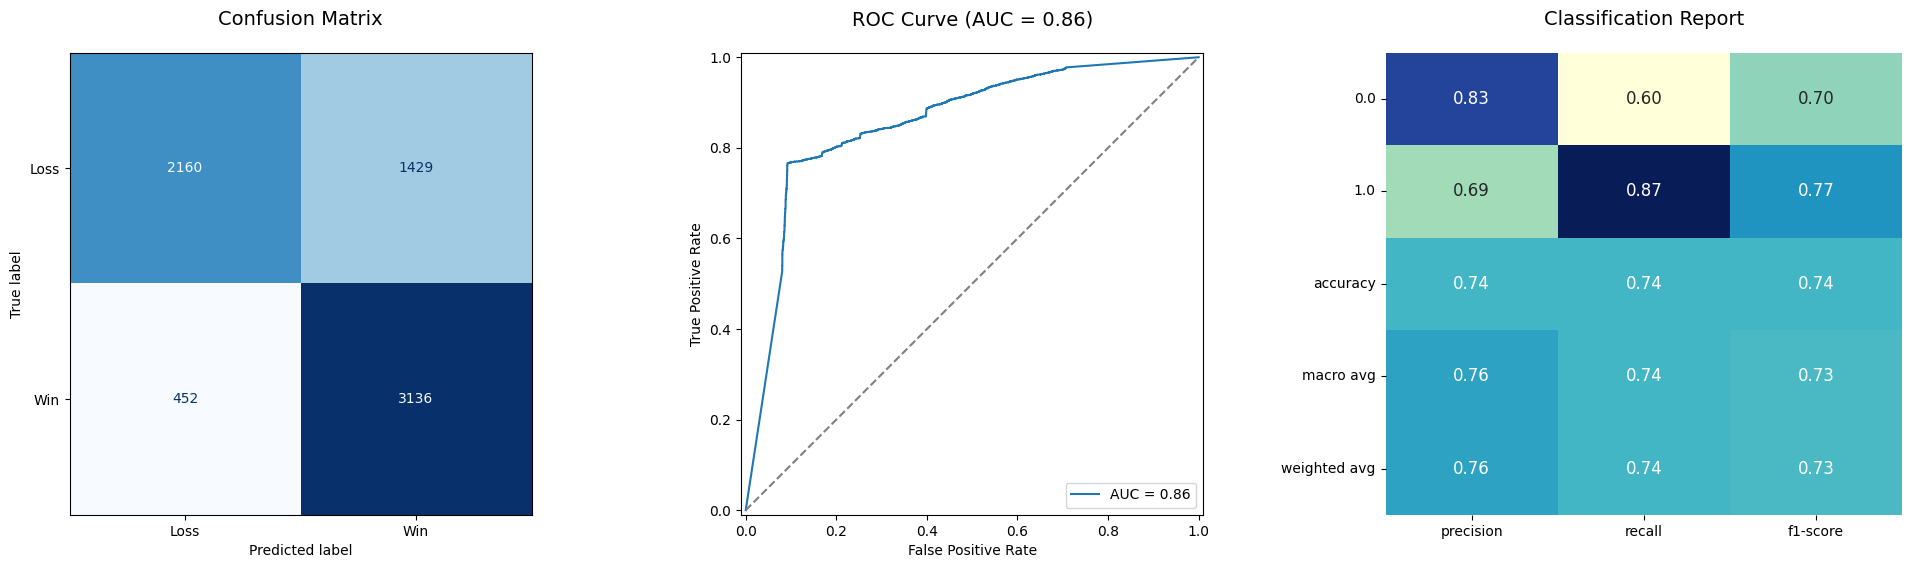

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,400 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,400 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 336)       │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │     10,784 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │         33 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,617 (186.00 KB)

 Trainable params: 47,617 (186.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8086 - loss: 0.4396 - val_accuracy: 0.8439 - val_loss: 0.3462 - learning_rate: 0.0010
Epoch 2/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8996 - loss: 0.2405 - val_accuracy: 0.8343 - val_loss: 0.3564 - learning_rate: 0.0010
Epoch 3/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9216 - loss: 0.1982 - val_accuracy: 0.8794 - val_loss: 0.2768 - learning_rate: 0.0010
Epoch 4/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9313 - loss: 0.1720 - val_accuracy: 0.8691 - val_loss: 0.3072 - learning_rate: 0.0010
Epoch 5/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9430 - loss: 0.1451 - val_accuracy: 0.8679 - val_loss: 0.3071 - learning_rate: 0.0010
Epoch 6/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9509 - loss: 0.1267 - val_accuracy: 0.8965 - val_loss: 0.2596 - learning_rate: 0.0010
Epoch 7/50
864/864 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9598 - loss: 0.1083 - 

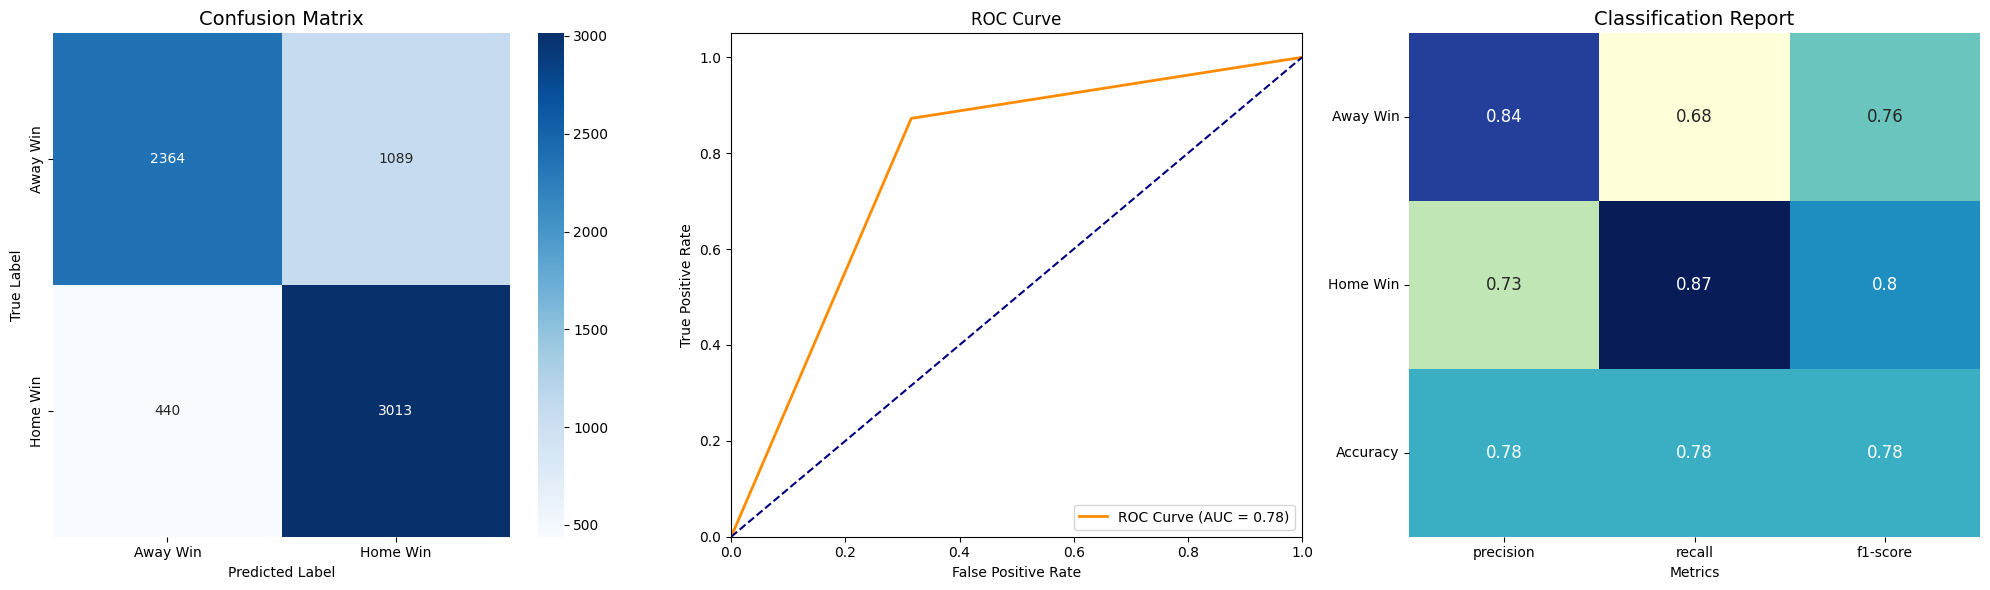

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 185 features

Performing cross-validation...
Cross-validation scores: [0.68940052 0.69526499 0.70178106]
Mean CV accuracy: 0.695 (+/- 0.010)

Training final model...

Model Evaluation:
Accuracy: 0.7361714451201854

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.59      0.69      3453
         1.0       0.68      0.89      0.77      3453

    accuracy                           0.74      6906
   macro avg       0.76      0.74      0.73      6906
weighted avg       0.76      0.74      0.73      6906


Prediction Confidence Analysis:
Mean confidence: 0.877
Min confidence: 0.500
Max confidence: 1.000


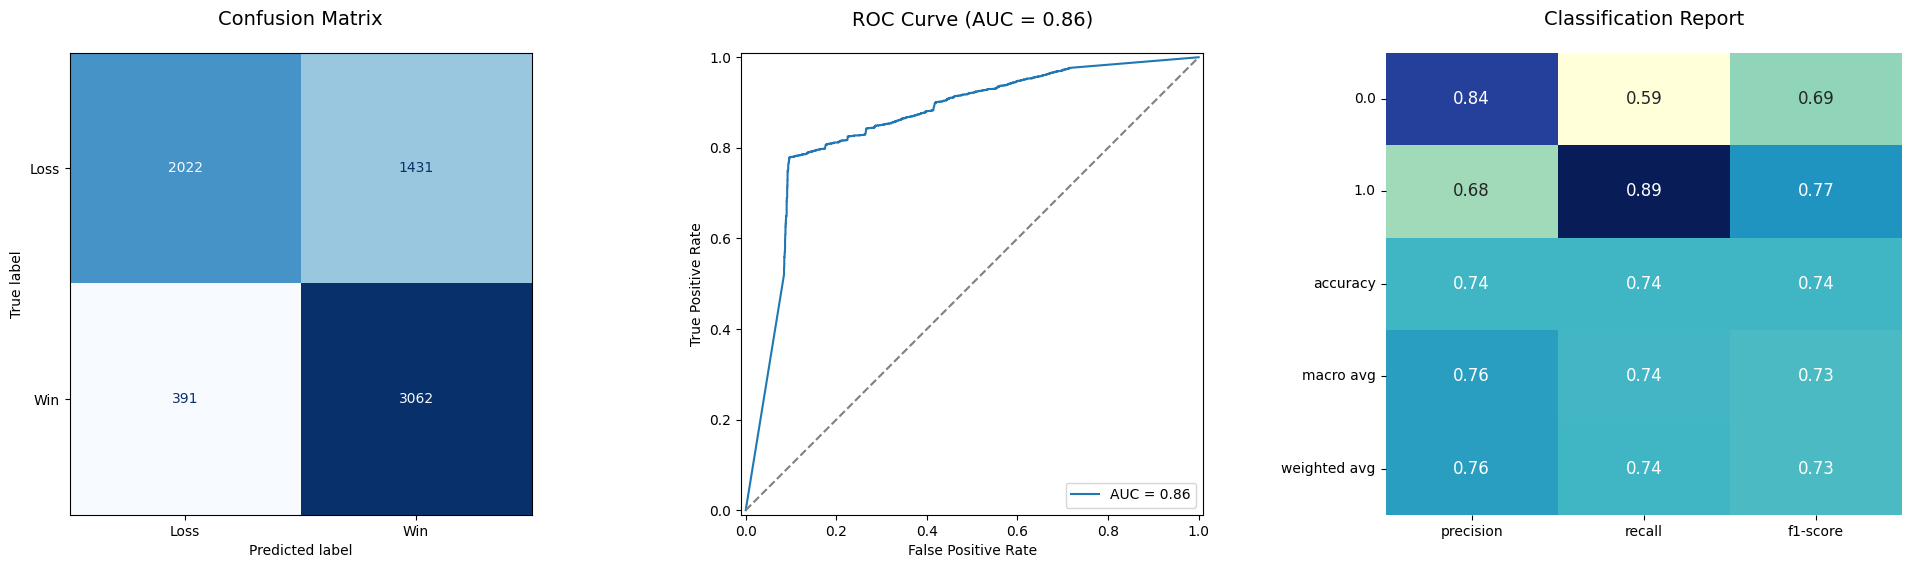

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_11      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,176 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,176 │ input_layer_11[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 336)       │          0 │ flatten_6[0][0],  │
│ (Concatenate)       │                   │            │ flatten_7[0][0],  │
│                     │                   │            │ input_layer_12[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32)        │     10,784 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │         33 │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,169 (184.25 KB)

 Trainable params: 47,169 (184.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8200 - loss: 0.4311 - val_accuracy: 0.8508 - val_loss: 0.3450 - learning_rate: 0.0010
Epoch 2/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8992 - loss: 0.2425 - val_accuracy: 0.8796 - val_loss: 0.2801 - learning_rate: 0.0010
Epoch 3/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9203 - loss: 0.1951 - val_accuracy: 0.9011 - val_loss: 0.2447 - learning_rate: 0.0010
Epoch 4/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9341 - loss: 0.1645 - val_accuracy: 0.8978 - val_loss: 0.2509 - learning_rate: 0.0010
Epoch 5/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9472 - loss: 0.1389 - val_accuracy: 0.9318 - val_loss: 0.1809 - learning_rate: 0.0010
Epoch 6/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9593 - loss: 0.1165 - val_accuracy: 0.8985 - val_loss: 0.2541 - learning_rate: 0.0010
Epoch 7/50
838/838 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9659 - loss: 0.0987 - 

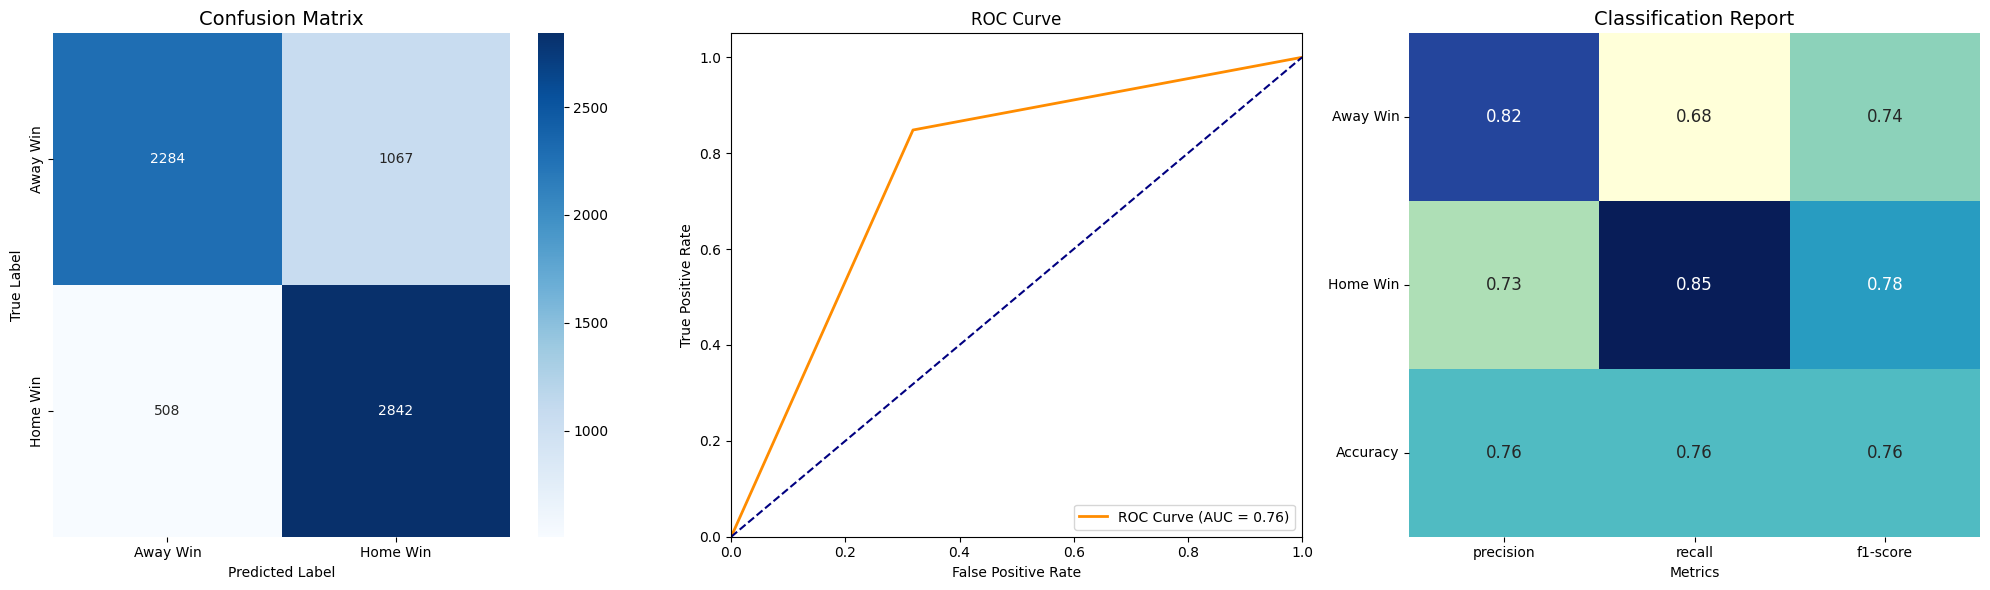

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 189 features

Performing cross-validation...
Cross-validation scores: [0.67897918 0.6695769  0.68196574]
Mean CV accuracy: 0.677 (+/- 0.011)

Training final model...

Model Evaluation:
Accuracy: 0.7243694970899865

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.58      0.68      3351
         1.0       0.68      0.87      0.76      3350

    accuracy                           0.72      6701
   macro avg       0.74      0.72      0.72      6701
weighted avg       0.74      0.72      0.72      6701


Prediction Confidence Analysis:
Mean confidence: 0.865
Min confidence: 0.500
Max confidence: 1.000


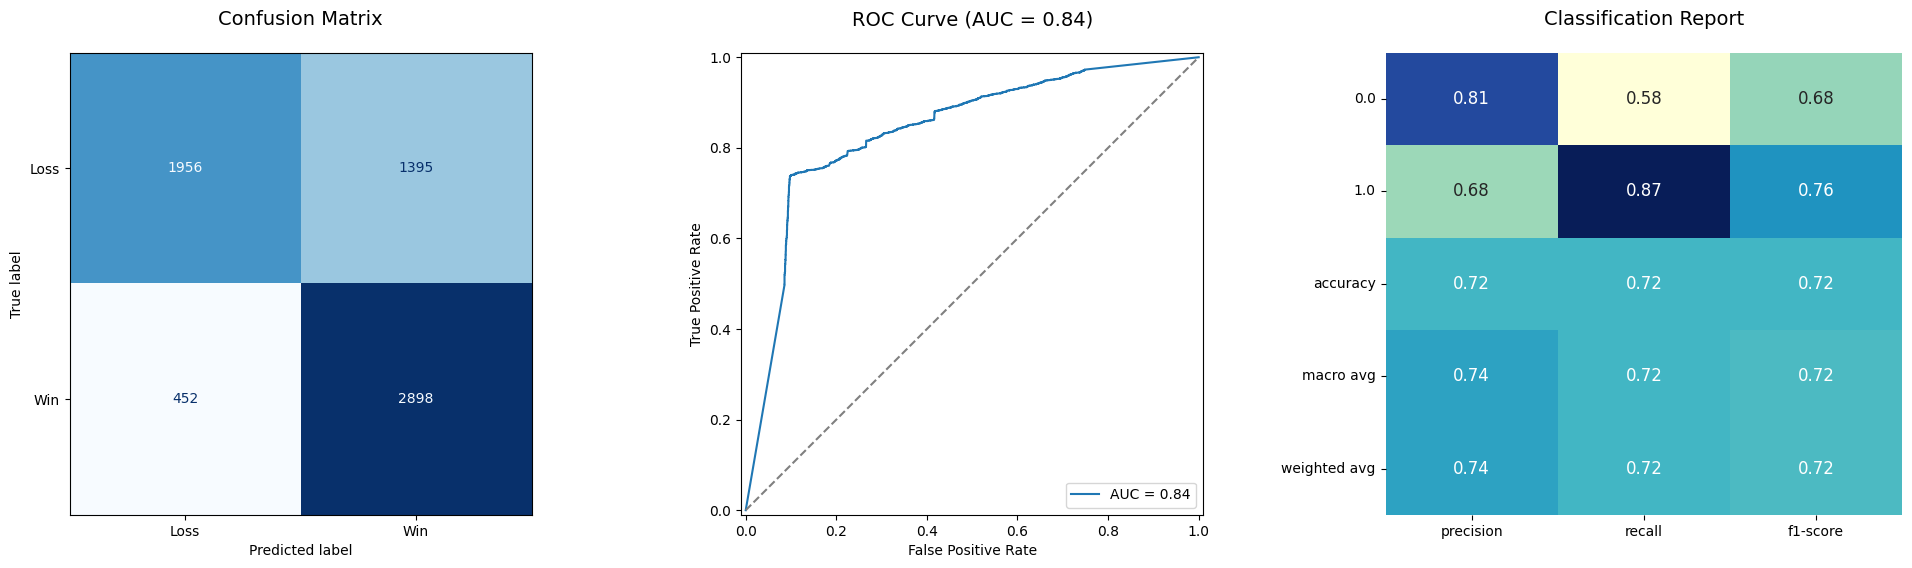

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,112 │ input_layer_13[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,112 │ input_layer_14[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 160)       │          0 │ home_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 160)       │          0 │ away_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 336)       │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0],  │
│                     │                   │            │ input_layer_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │     10,784 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         33 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,041 (183.75 KB)

 Trainable params: 47,041 (183.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8163 - loss: 0.4327 - val_accuracy: 0.8214 - val_loss: 0.3931 - learning_rate: 0.0010
Epoch 2/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9011 - loss: 0.2423 - val_accuracy: 0.8576 - val_loss: 0.3287 - learning_rate: 0.0010
Epoch 3/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9181 - loss: 0.1989 - val_accuracy: 0.8615 - val_loss: 0.3105 - learning_rate: 0.0010
Epoch 4/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9338 - loss: 0.1695 - val_accuracy: 0.8887 - val_loss: 0.2708 - learning_rate: 0.0010
Epoch 5/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9447 - loss: 0.1412 - val_accuracy: 0.8863 - val_loss: 0.2812 - learning_rate: 0.0010
Epoch 6/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9555 - loss: 0.1202 - val_accuracy: 0.8913 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 7/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9614 - loss: 0.1059
Ep

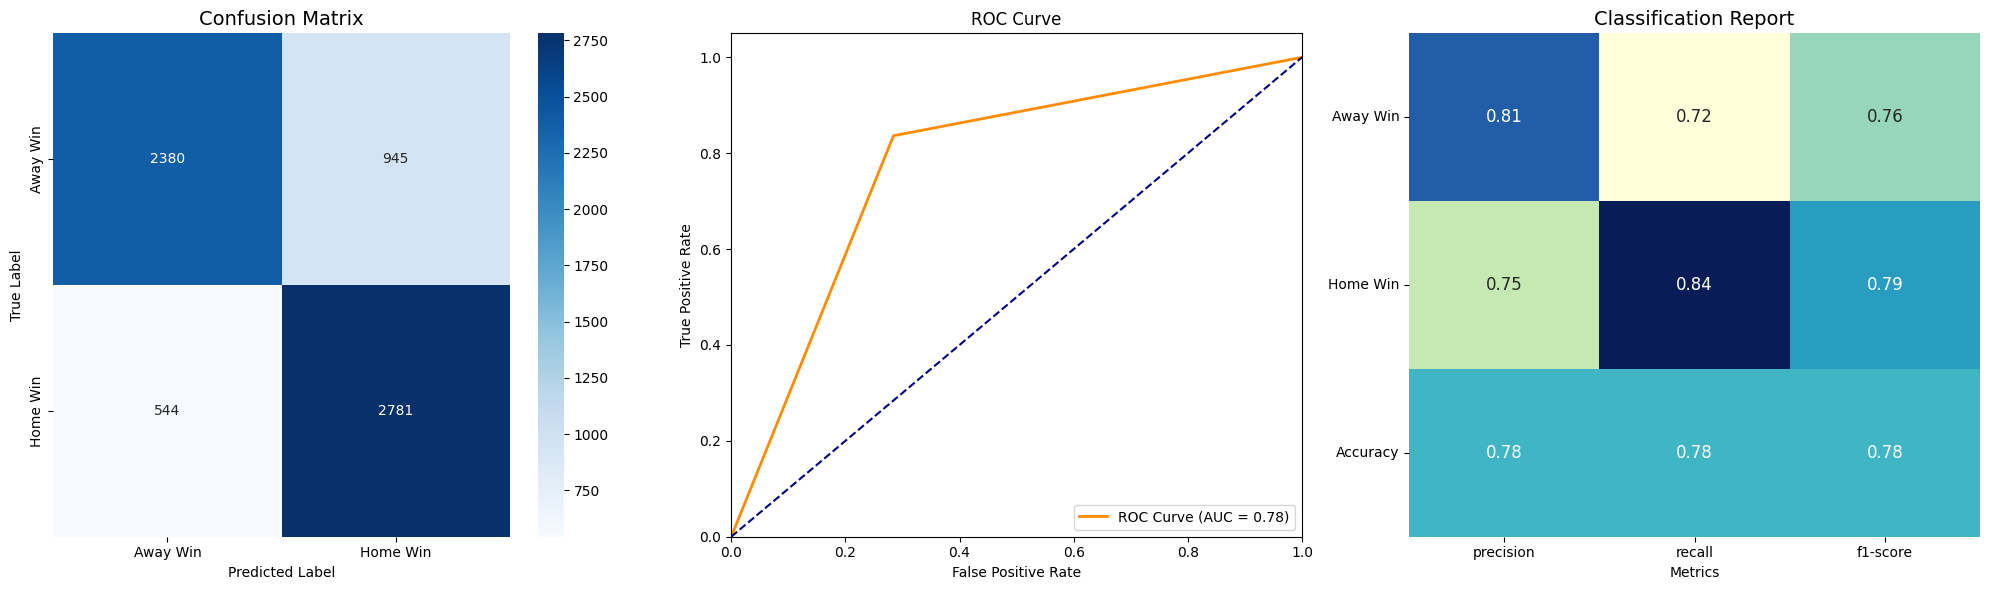

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 191 features

Performing cross-validation...
Cross-validation scores: [0.68294609 0.68020305 0.68663283]
Mean CV accuracy: 0.683 (+/- 0.005)

Training final model...

Model Evaluation:
Accuracy: 0.7157894736842105

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.59      0.67      3325
         1.0       0.67      0.84      0.75      3325

    accuracy                           0.72      6650
   macro avg       0.73      0.72      0.71      6650
weighted avg       0.73      0.72      0.71      6650


Prediction Confidence Analysis:
Mean confidence: 0.865
Min confidence: 0.500
Max confidence: 1.000


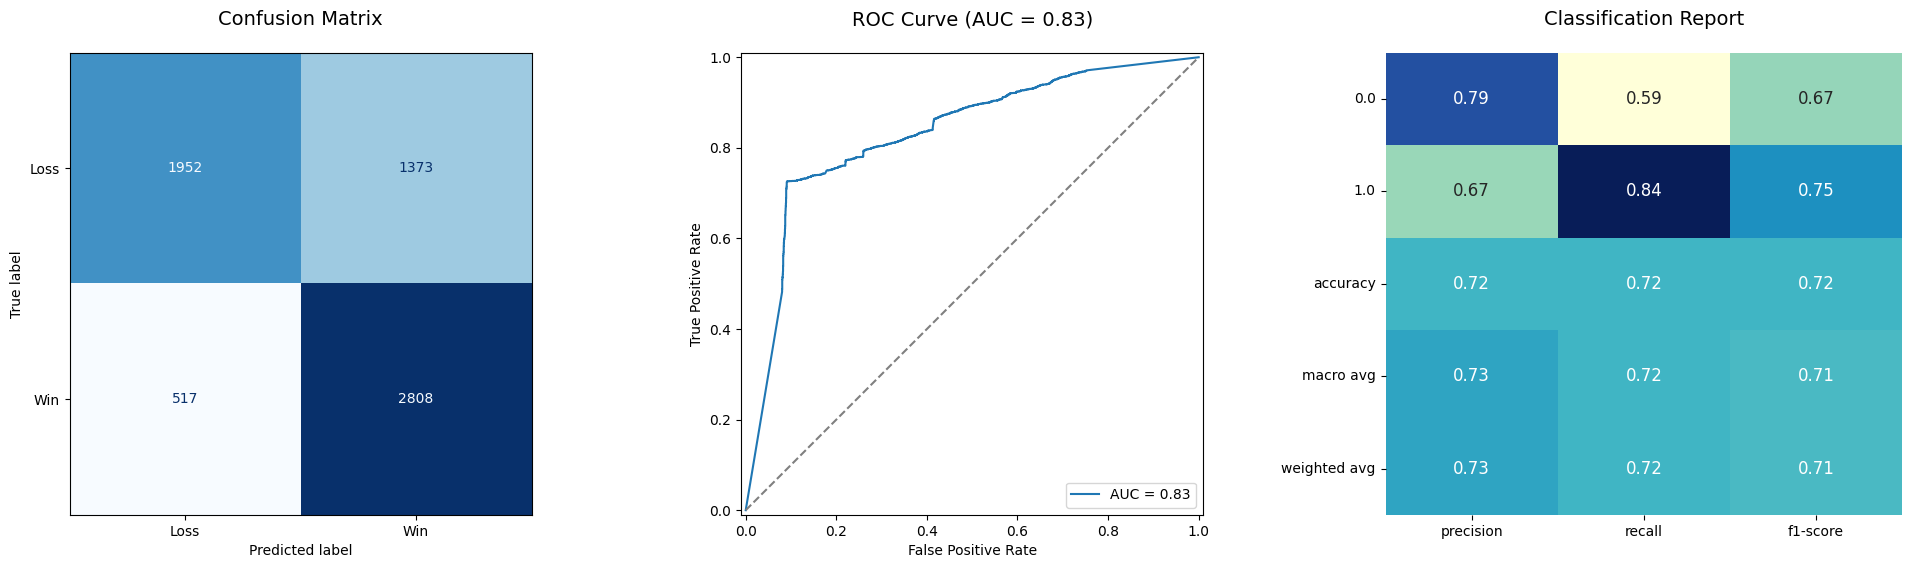

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,432 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,432 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 336)       │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ flatten_11[0][0], │
│                     │                   │            │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │     10,784 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 47,681 (186.25 KB)

 Trainable params: 47,681 (186.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7818 - loss: 0.4603 - val_accuracy: 0.8689 - val_loss: 0.3000 - learning_rate: 0.0010
Epoch 2/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8991 - loss: 0.2470 - val_accuracy: 0.8275 - val_loss: 0.3559 - learning_rate: 0.0010
Epoch 3/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9137 - loss: 0.2086 - val_accuracy: 0.8664 - val_loss: 0.2995 - learning_rate: 0.0010
Epoch 4/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9306 - loss: 0.1770 - val_accuracy: 0.8719 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 5/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9449 - loss: 0.1489 - val_accuracy: 0.8984 - val_loss: 0.2491 - learning_rate: 0.0010
Epoch 6/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9518 - loss: 0.1305 - val_accuracy: 0.8765 - val_loss: 0.3051 - learning_rate: 0.0010
Epoch 7/50
842/842 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9596 - loss: 0.1135 - 

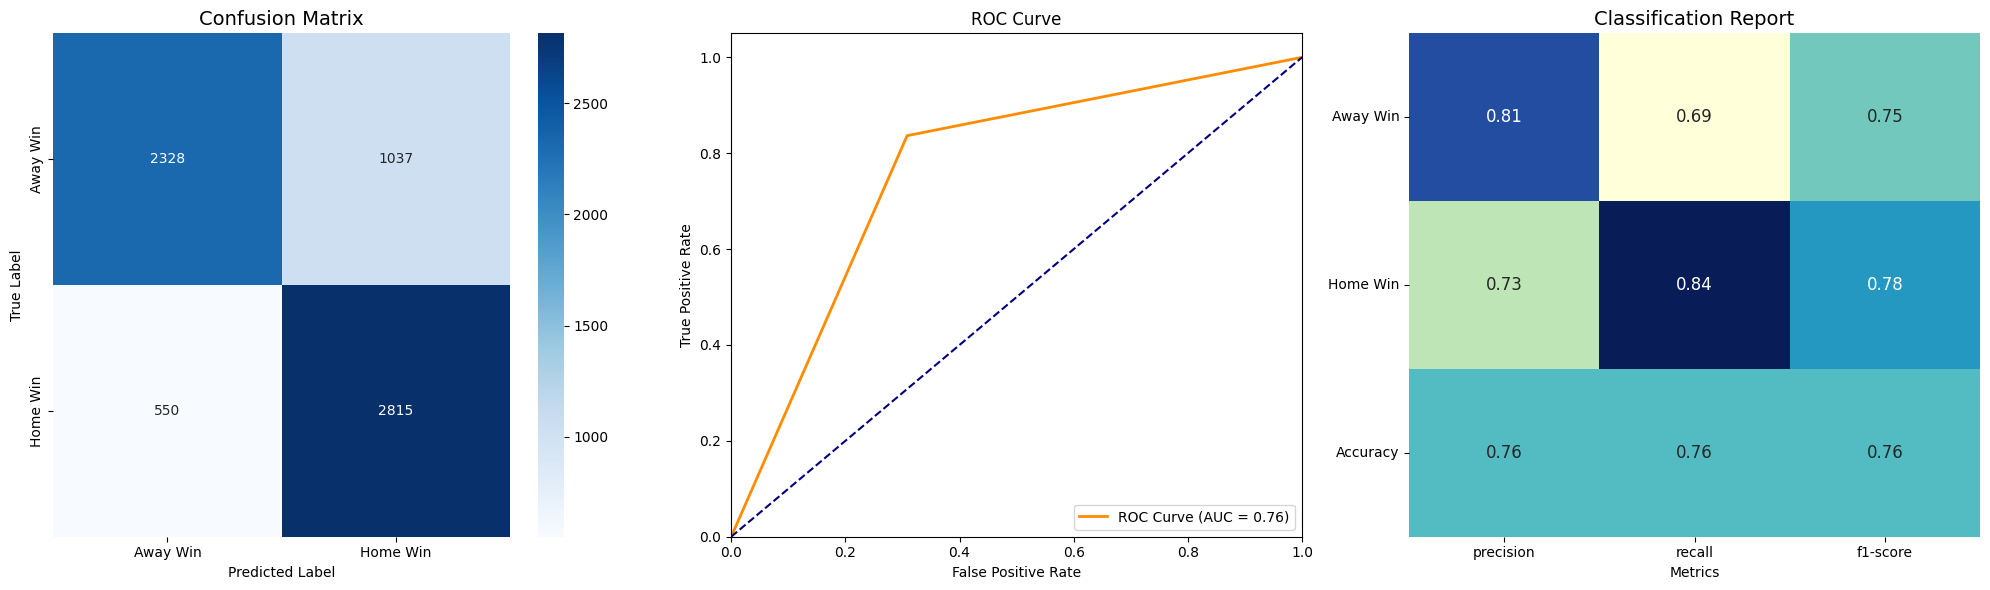

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 188 features

Performing cross-validation...
Cross-validation scores: [0.67847988 0.67658531 0.68111904]
Mean CV accuracy: 0.679 (+/- 0.004)

Training final model...

Model Evaluation:
Accuracy: 0.7212481426448737

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.59      0.68      3365
         1.0       0.68      0.85      0.75      3365

    accuracy                           0.72      6730
   macro avg       0.74      0.72      0.72      6730
weighted avg       0.74      0.72      0.72      6730


Prediction Confidence Analysis:
Mean confidence: 0.864
Min confidence: 0.500
Max confidence: 1.000


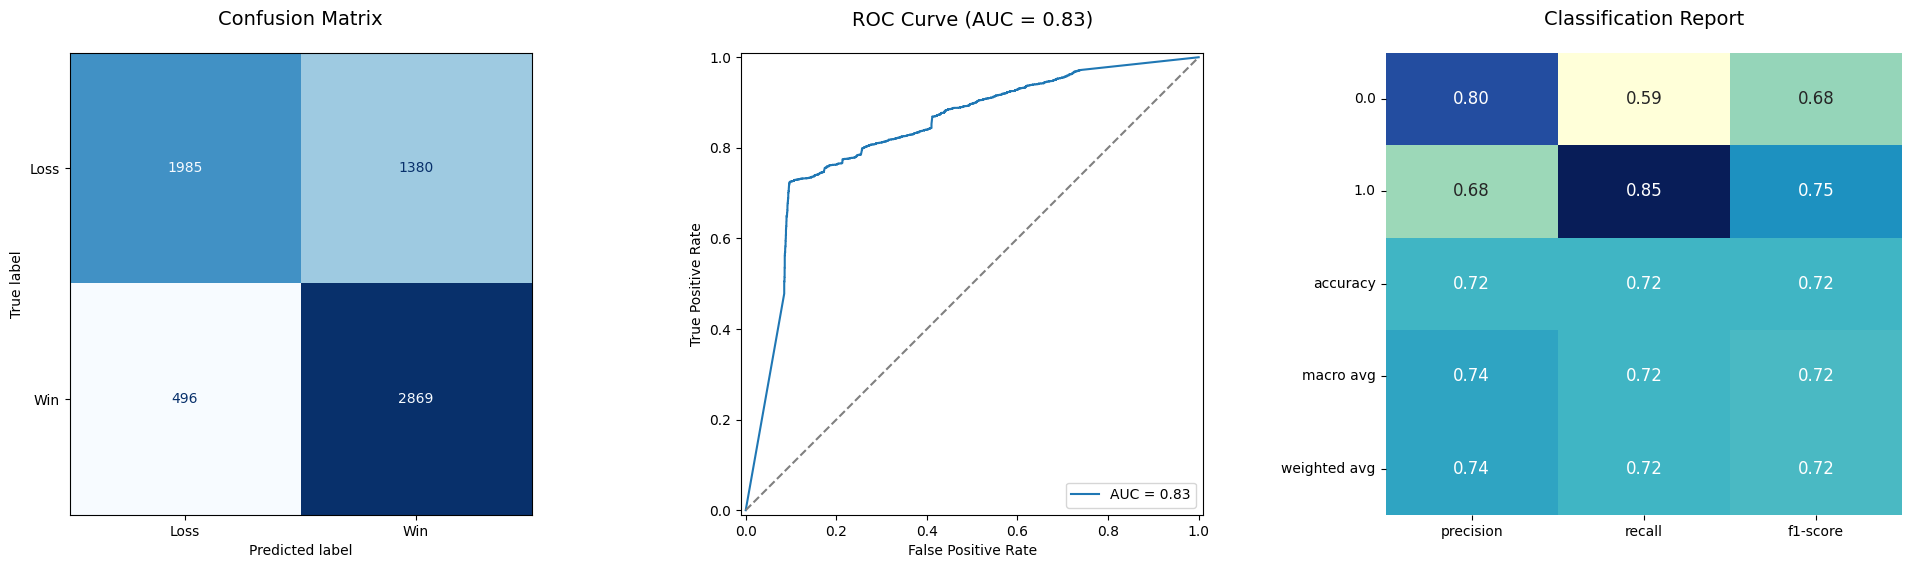

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_20      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     19,264 │ input_layer_19[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     19,264 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_12          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 336)       │          0 │ flatten_12[0][0], │
│ (Concatenate)       │                   │            │ flatten_13[0][0], │
│                     │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │     10,784 │ concatenate_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         33 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,345 (192.75 KB)

 Trainable params: 49,345 (192.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8262 - loss: 0.4463 - val_accuracy: 0.8237 - val_loss: 0.3698 - learning_rate: 0.0010
Epoch 2/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9046 - loss: 0.2350 - val_accuracy: 0.8712 - val_loss: 0.2844 - learning_rate: 0.0010
Epoch 3/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9233 - loss: 0.1929 - val_accuracy: 0.8685 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 4/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9335 - loss: 0.1624 - val_accuracy: 0.8768 - val_loss: 0.2818 - learning_rate: 0.0010
Epoch 5/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9518 - loss: 0.1331 - val_accuracy: 0.8865 - val_loss: 0.2608 - learning_rate: 0.0010
Epoch 6/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9599 - loss: 0.1141 - val_accuracy: 0.8755 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 7/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9687 - loss: 0.0904 - 

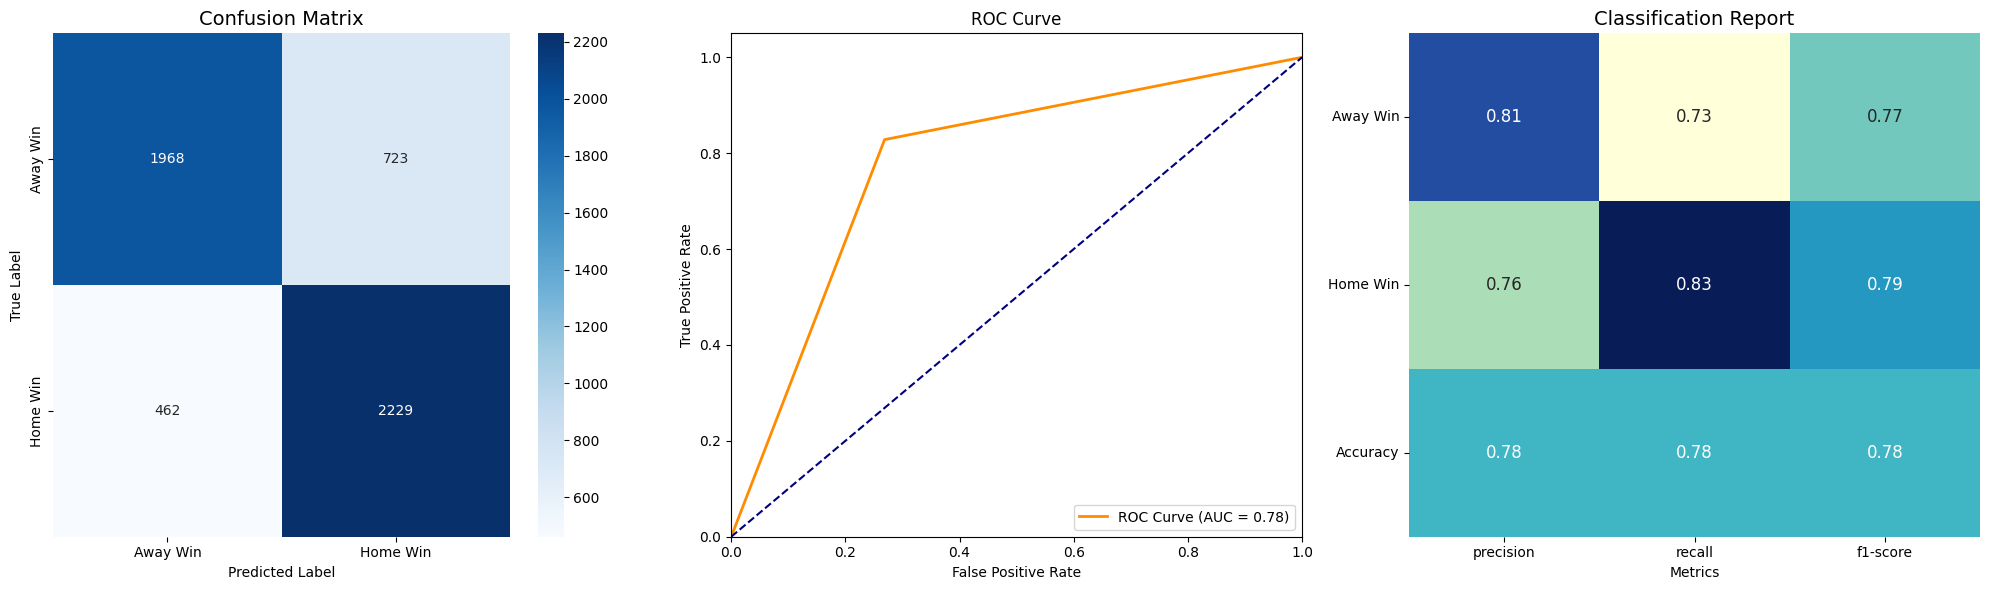

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 189 features

Performing cross-validation...
Cross-validation scores: [0.68575808 0.688223   0.69296167]
Mean CV accuracy: 0.689 (+/- 0.006)

Training final model...

Model Evaluation:
Accuracy: 0.7276105536975103

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.60      0.69      2691
         1.0       0.68      0.85      0.76      2691

    accuracy                           0.73      5382
   macro avg       0.74      0.73      0.72      5382
weighted avg       0.74      0.73      0.72      5382


Prediction Confidence Analysis:
Mean confidence: 0.866
Min confidence: 0.500
Max confidence: 1.000


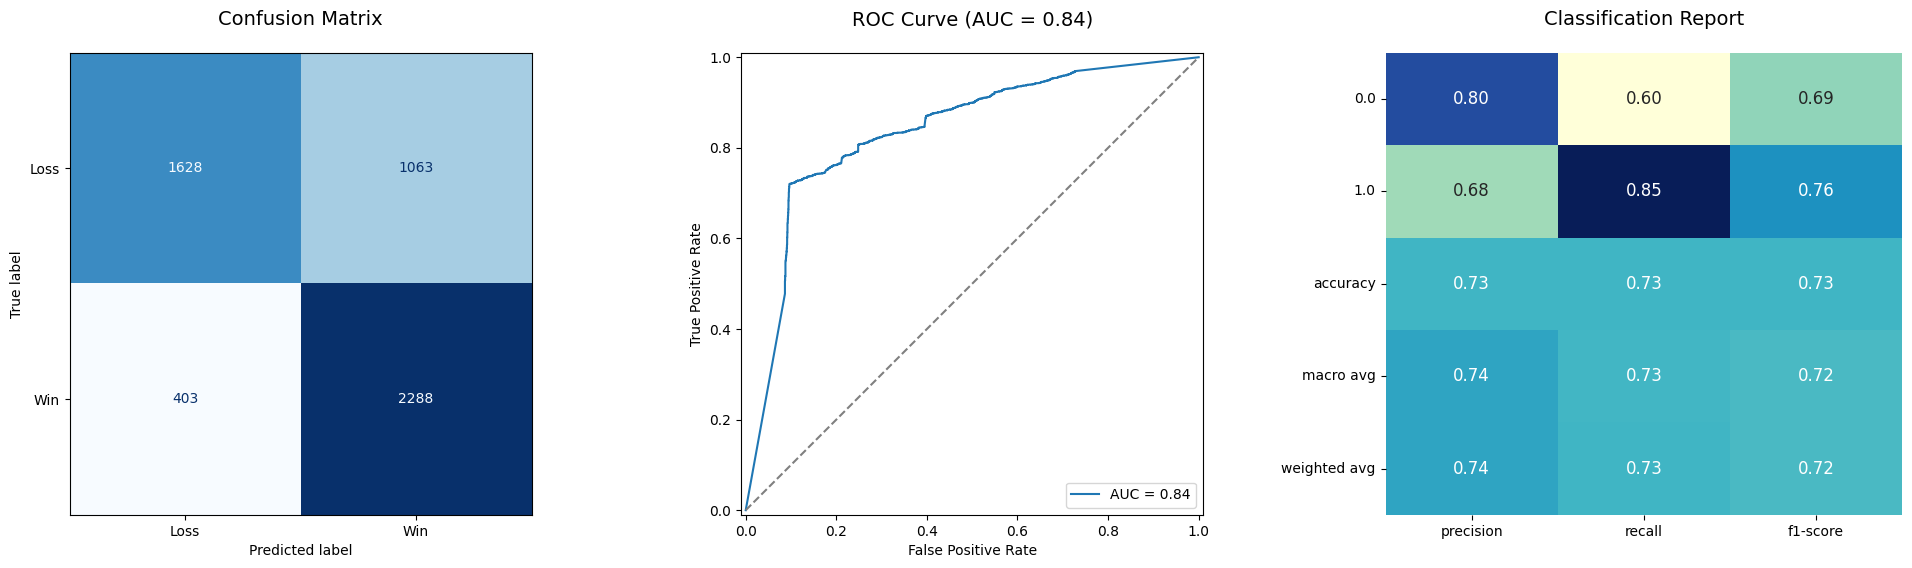

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     18,944 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     18,944 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_24      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 336)       │          0 │ flatten_14[0][0], │
│ (Concatenate)       │                   │            │ flatten_15[0][0], │
│                     │                   │            │ input_layer_24[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 32)        │     10,784 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │         33 │ dense_20[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 48,705 (190.25 KB)

 Trainable params: 48,705 (190.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8091 - loss: 0.4405 - val_accuracy: 0.8533 - val_loss: 0.3476 - learning_rate: 0.0010
Epoch 2/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9016 - loss: 0.2368 - val_accuracy: 0.8759 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 3/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9180 - loss: 0.1944 - val_accuracy: 0.8821 - val_loss: 0.2943 - learning_rate: 0.0010
Epoch 4/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9337 - loss: 0.1659 - val_accuracy: 0.8860 - val_loss: 0.2852 - learning_rate: 0.0010
Epoch 5/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9511 - loss: 0.1354 - val_accuracy: 0.9185 - val_loss: 0.2104 - learning_rate: 0.0010
Epoch 6/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9617 - loss: 0.1099 - val_accuracy: 0.9270 - val_loss: 0.2005 - learning_rate: 0.0010
Epoch 7/50
812/812 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9683 - loss: 0.0947 - 

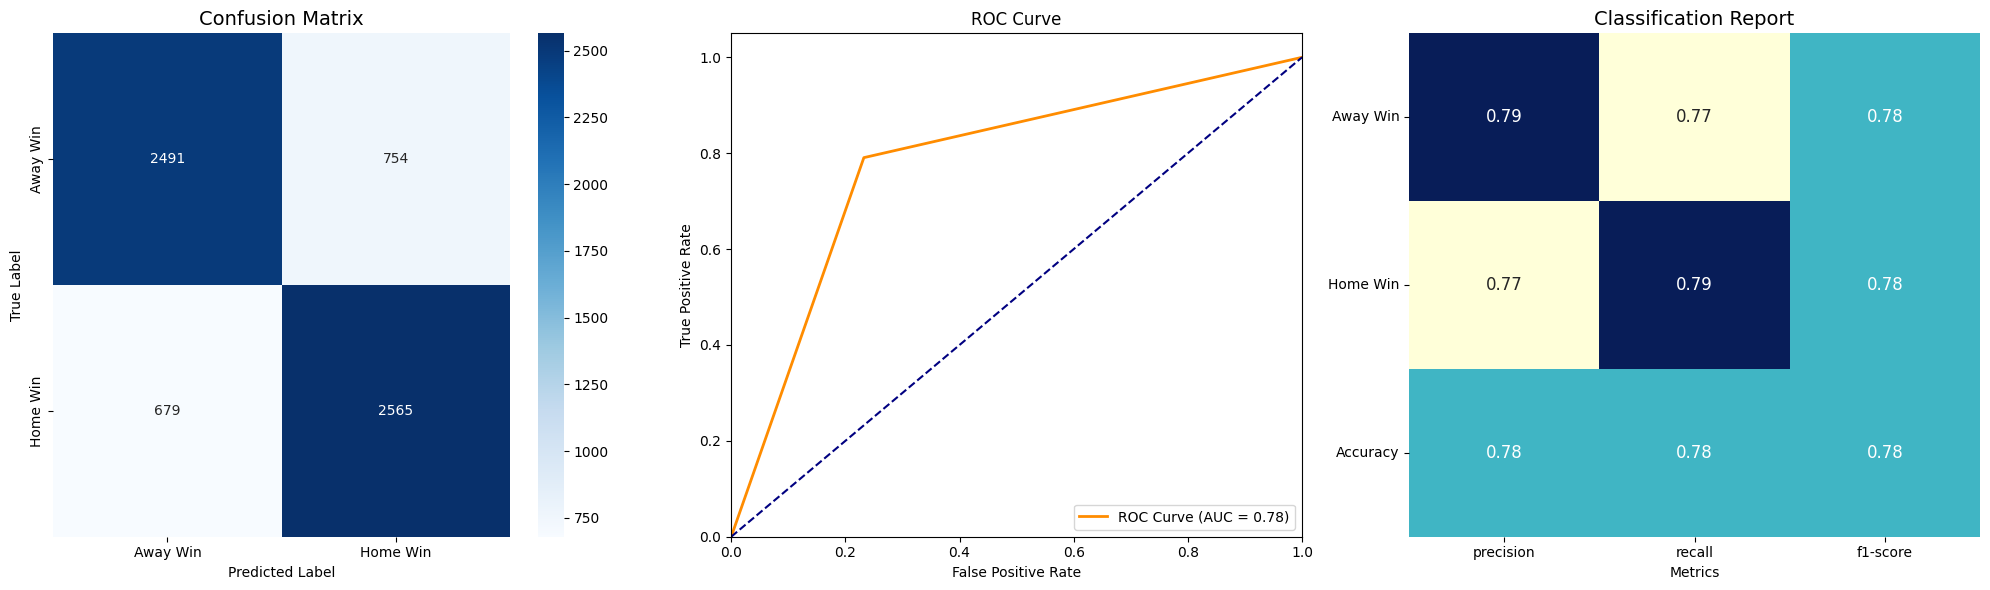

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 197 features

Performing cross-validation...
Cross-validation scores: [0.66801526 0.67206103 0.6709051 ]
Mean CV accuracy: 0.670 (+/- 0.003)

Training final model...

Model Evaluation:
Accuracy: 0.7105871474803513

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.59      0.67      3245
         1.0       0.67      0.83      0.74      3244

    accuracy                           0.71      6489
   macro avg       0.72      0.71      0.71      6489
weighted avg       0.72      0.71      0.71      6489


Prediction Confidence Analysis:
Mean confidence: 0.855
Min confidence: 0.500
Max confidence: 1.000


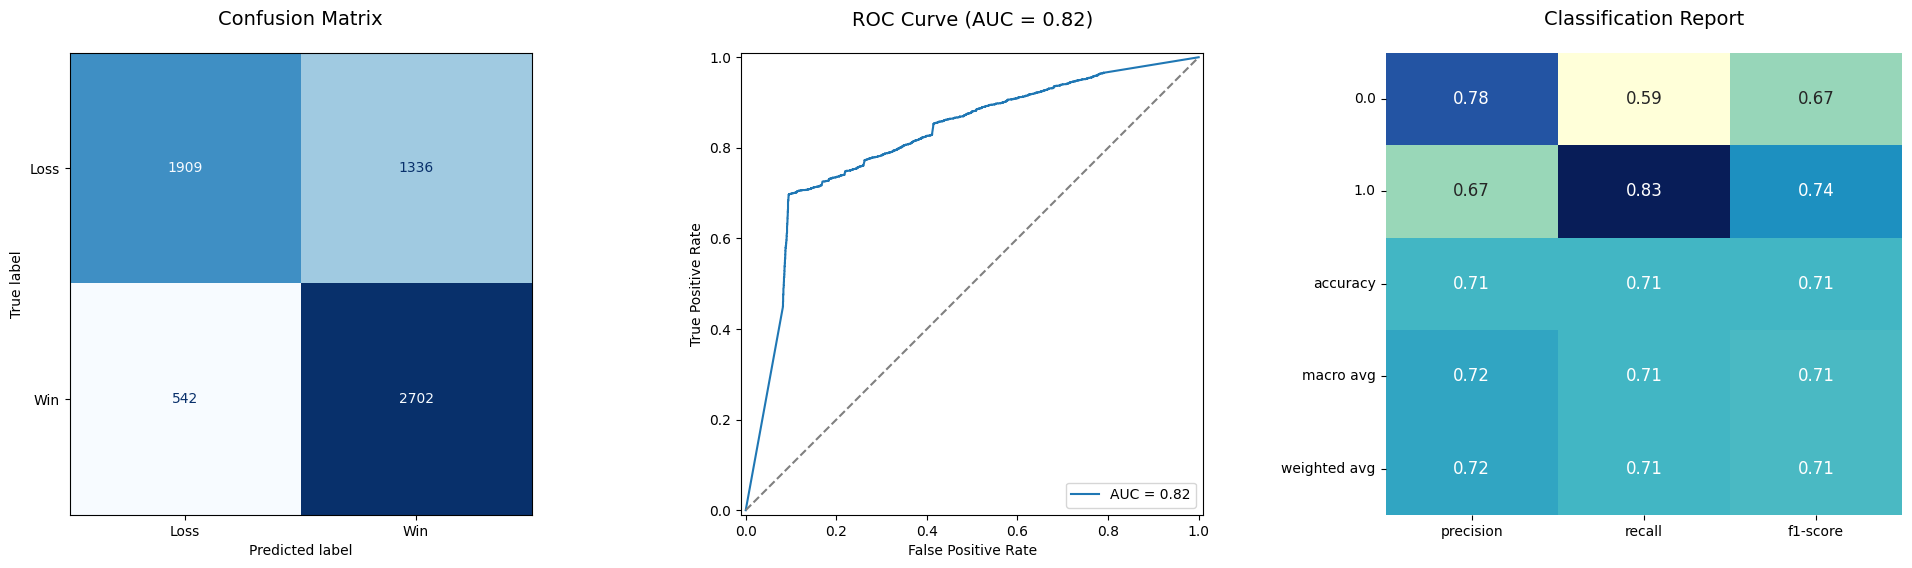

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     19,328 │ input_layer_25[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     19,328 │ input_layer_26[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 336)       │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_17[0][0], │
│                     │                   │            │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 32)        │     10,784 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 1)         │         33 │ dense_22[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,473 (193.25 KB)

 Trainable params: 49,473 (193.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8043 - loss: 0.4451 - val_accuracy: 0.8078 - val_loss: 0.3992 - learning_rate: 0.0010
Epoch 2/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8943 - loss: 0.2501 - val_accuracy: 0.8397 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 3/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9156 - loss: 0.2058 - val_accuracy: 0.8859 - val_loss: 0.2569 - learning_rate: 0.0010
Epoch 4/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9300 - loss: 0.1723 - val_accuracy: 0.9078 - val_loss: 0.2175 - learning_rate: 0.0010
Epoch 5/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9454 - loss: 0.1456 - val_accuracy: 0.8893 - val_loss: 0.2694 - learning_rate: 0.0010
Epoch 6/50
822/822 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9567 - loss: 0.1218 - val_accuracy: 0.8964 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 7/50
811/822 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9656 - loss: 0.1030
Ep

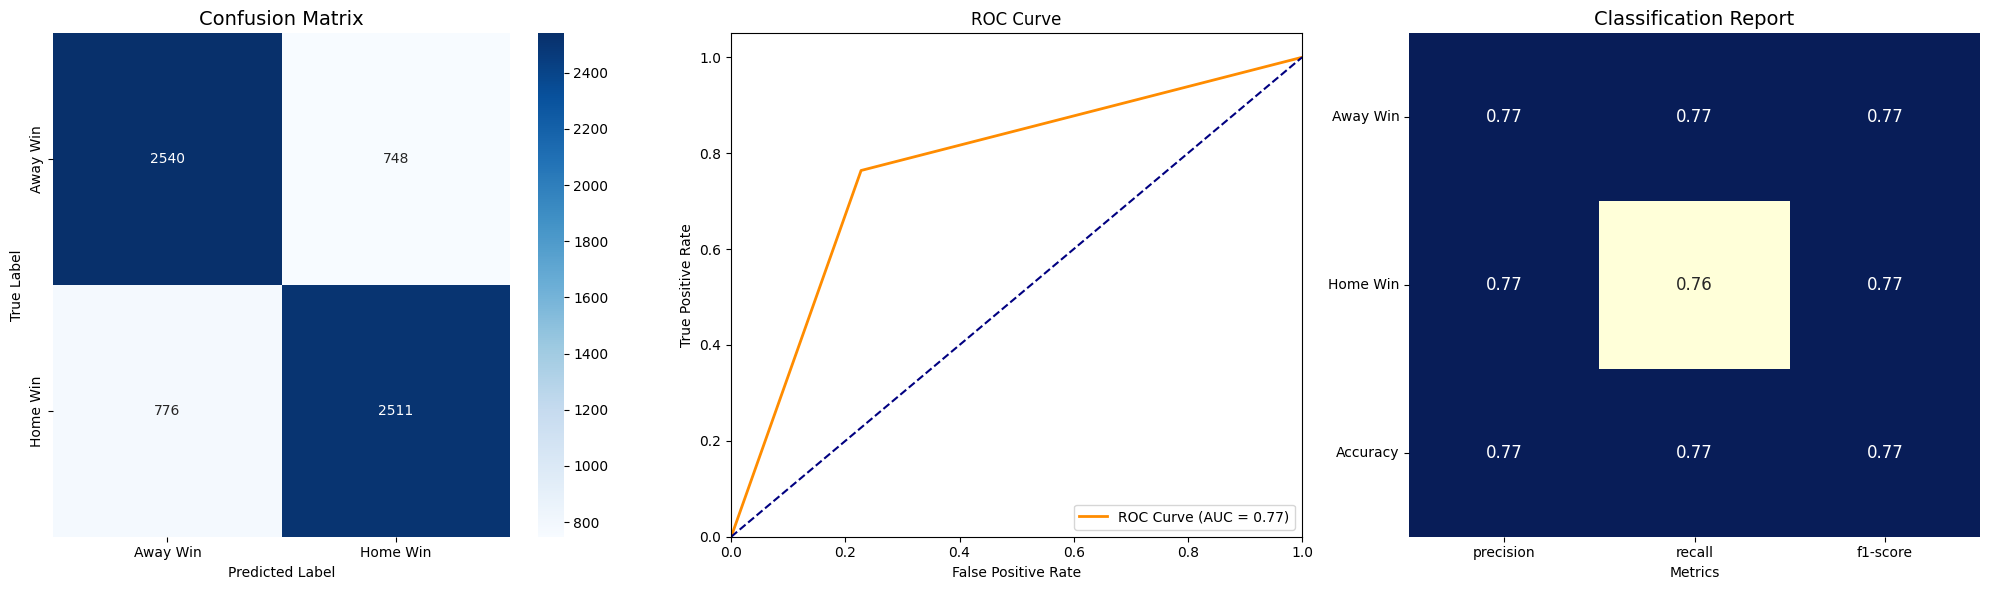

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 201 features

Performing cross-validation...
Cross-validation scores: [0.65609673 0.64909879 0.65685603]
Mean CV accuracy: 0.654 (+/- 0.007)

Training final model...

Model Evaluation:
Accuracy: 0.6926235741444867

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.57      0.65      3288
         1.0       0.66      0.81      0.73      3287

    accuracy                           0.69      6575
   macro avg       0.70      0.69      0.69      6575
weighted avg       0.70      0.69      0.69      6575


Prediction Confidence Analysis:
Mean confidence: 0.848
Min confidence: 0.500
Max confidence: 1.000


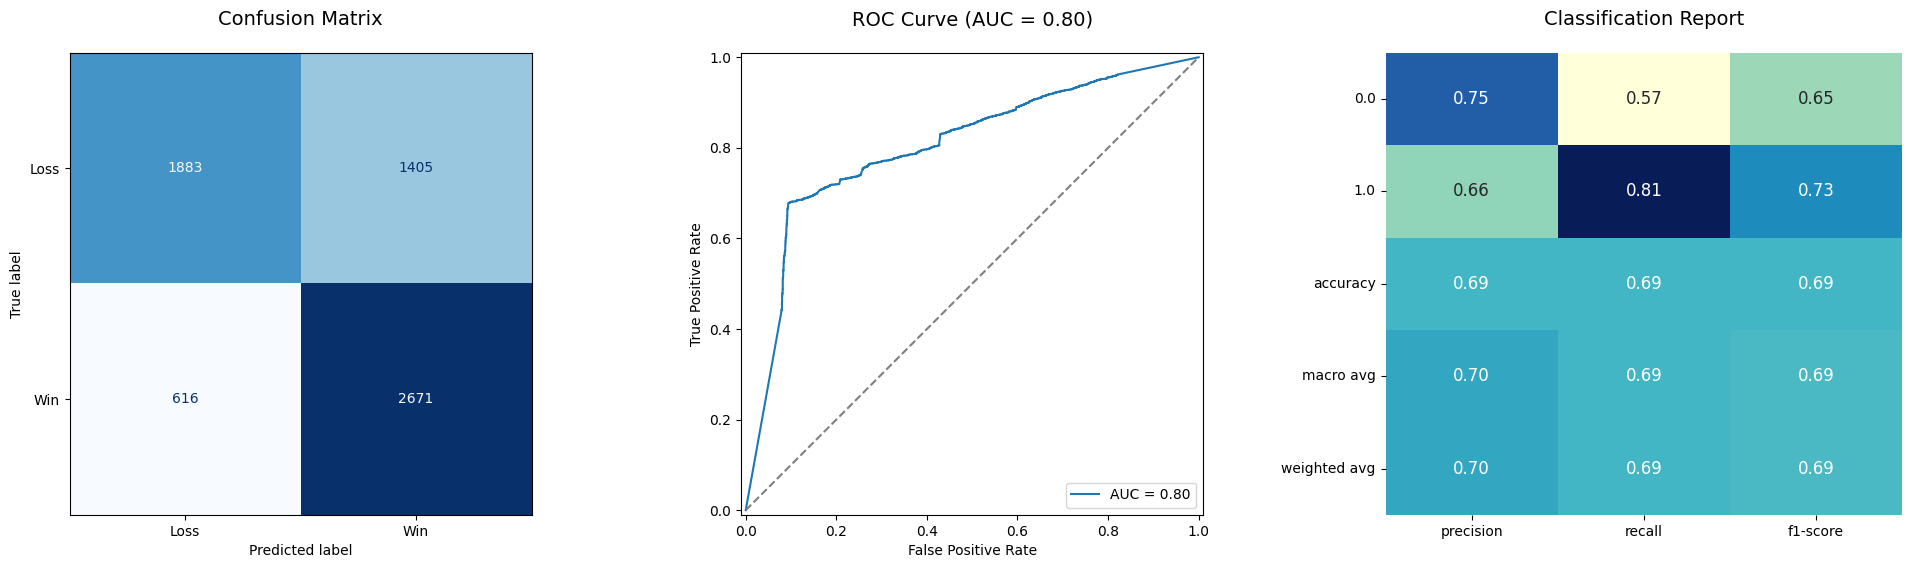

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ home_embedding      │ (None, 5, 32)     │     19,648 │ input_layer_28[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ away_embedding      │ (None, 5, 32)     │     19,648 │ input_layer_29[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 160)       │          0 │ home_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 160)       │          0 │ away_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_30      │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 336)       │          0 │ flatten_18[0][0], │
│ (Concatenate)       │                   │            │ flatten_19[0][0], │
│                     │                   │            │ input_layer_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 32)        │     10,784 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 1)         │         33 │ dense_24[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,113 (195.75 KB)

 Trainable params: 50,113 (195.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7859 - loss: 0.4558 - val_accuracy: 0.8367 - val_loss: 0.3785 - learning_rate: 0.0010
Epoch 2/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8955 - loss: 0.2548 - val_accuracy: 0.8569 - val_loss: 0.3386 - learning_rate: 0.0010
Epoch 3/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9159 - loss: 0.2095 - val_accuracy: 0.9017 - val_loss: 0.2470 - learning_rate: 0.0010
Epoch 4/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9289 - loss: 0.1780 - val_accuracy: 0.8869 - val_loss: 0.2837 - learning_rate: 0.0010
Epoch 5/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9464 - loss: 0.1446 - val_accuracy: 0.9138 - val_loss: 0.2247 - learning_rate: 0.0010
Epoch 6/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9584 - loss: 0.1176 - val_accuracy: 0.8988 - val_loss: 0.2653 - learning_rate: 0.0010
Epoch 7/50
861/861 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9643 - loss: 0.1031 - 

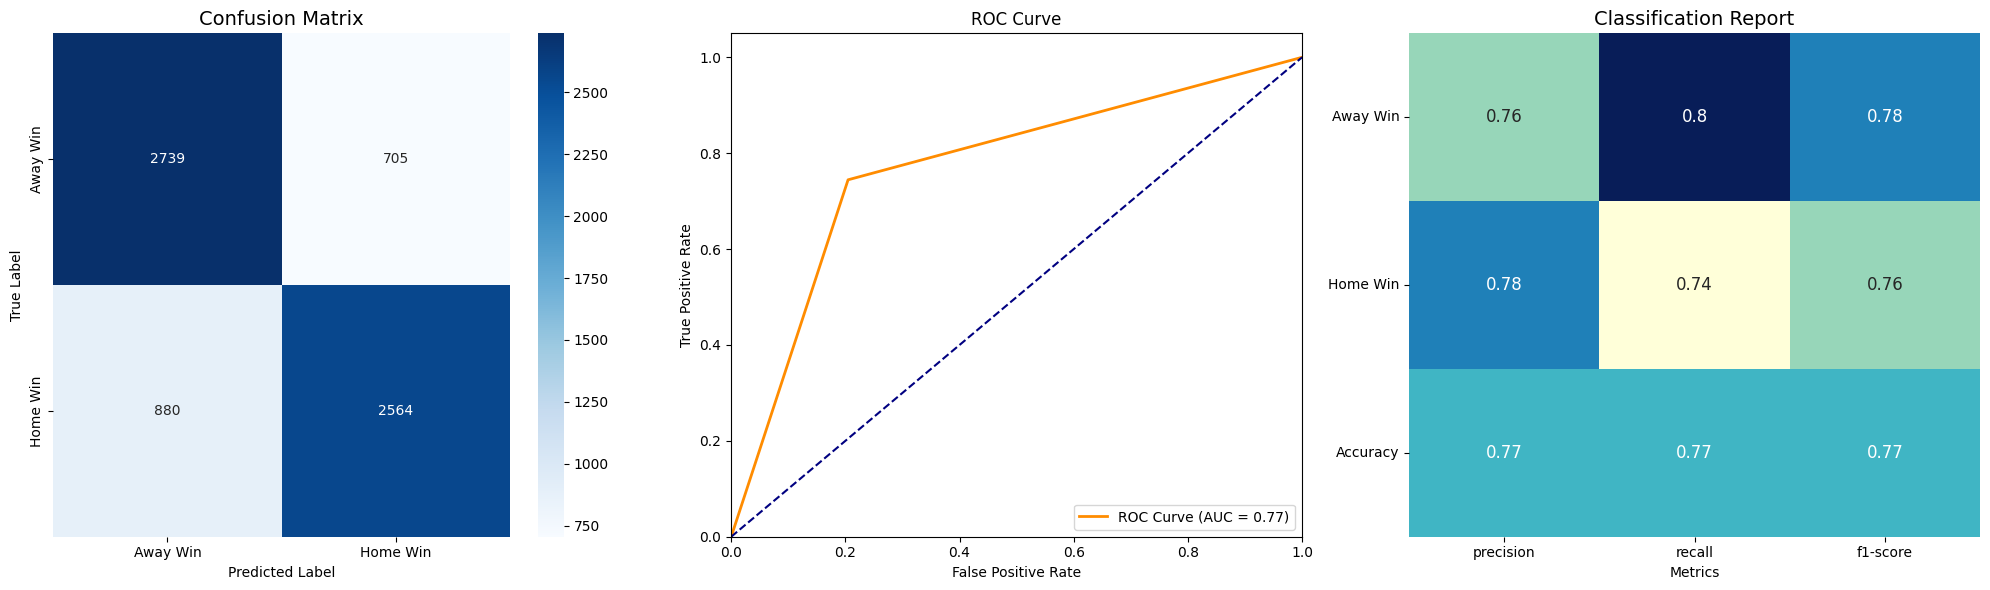

Scaling features...
Applying PCA...
Reduced dimensions from 320 to 200 features

Performing cross-validation...
Cross-validation scores: [0.64710366 0.65167683 0.64285714]
Mean CV accuracy: 0.647 (+/- 0.007)

Training final model...

Model Evaluation:
Accuracy: 0.68568524970964

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.56      0.64      3444
         1.0       0.65      0.81      0.72      3444

    accuracy                           0.69      6888
   macro avg       0.70      0.69      0.68      6888
weighted avg       0.70      0.69      0.68      6888


Prediction Confidence Analysis:
Mean confidence: 0.839
Min confidence: 0.500
Max confidence: 1.000


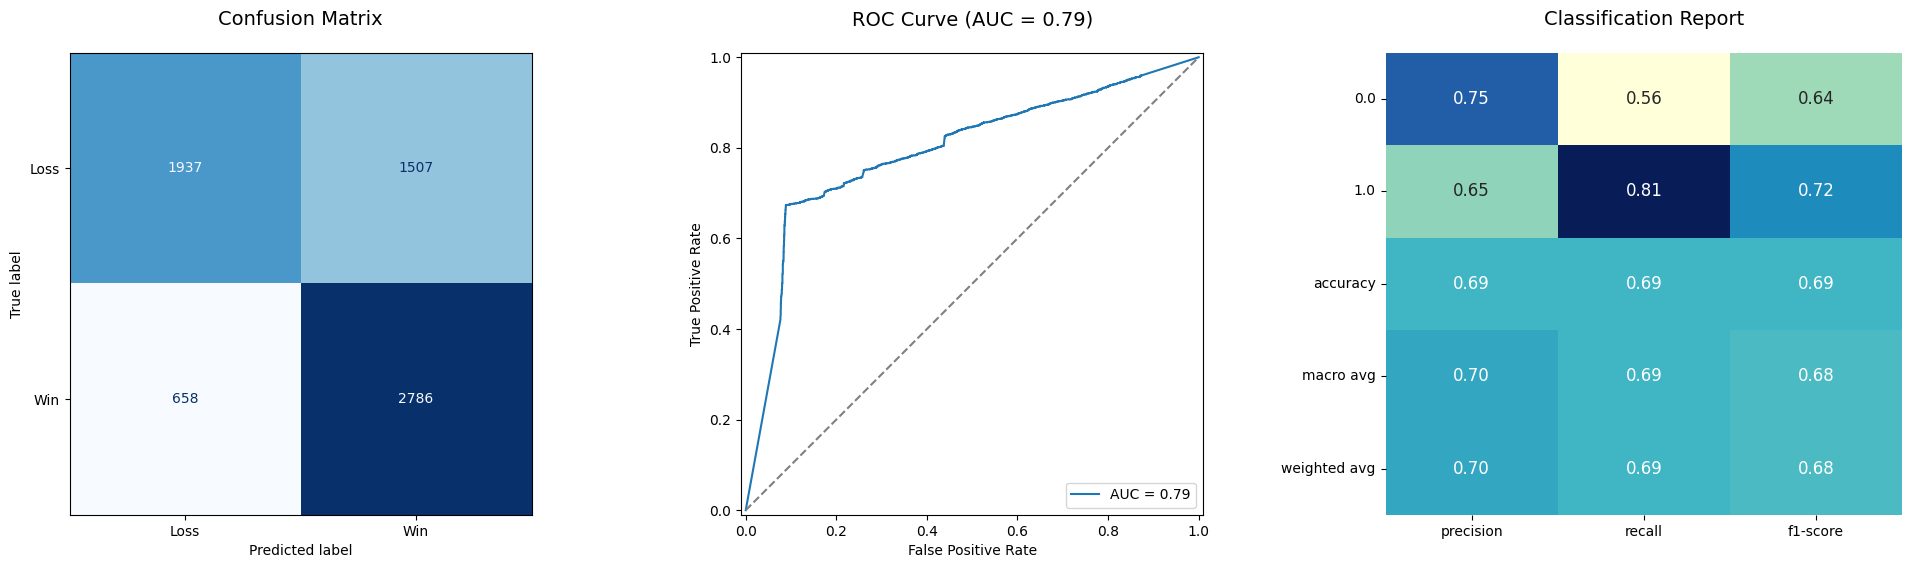

In [62]:
year_on_year_models = generate_models(year_on_year_datasets)

In [63]:
save_generated_models(year_on_year_models, year_on_year_datasets)